# Data Exploration

In this notebook describe your data exploration steps.

## Install & Import dependencies

In [3]:
%%capture
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install sqlalchemy

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Load data

In [5]:
cloud_df = pd.read_sql_table("cloud_data", "sqlite:///data.sqlite")
# bedeckungsgrad: estimated coverage of the visible sky with clouds in eighths

# Replace -999 with NaN
cloud_df.replace(-999, pd.NA, inplace=True)

# Keep only the date
cloud_df["date"] = pd.to_datetime(cloud_df["mess_datum"]).dt.date
cloud_df.drop("mess_datum", axis=1, inplace=True)

# Group by mess_datum and calculate the average of bedeckungsgrad
cloud_df = cloud_df.groupby("date").mean().reset_index()

# Drop the stations_id and the wolkendichte columns
# NOTE: wolkendichte is currently not used - drop to save memory
cloud_df.drop(["stations_id", "wolkendichte"], axis=1, inplace=True)

print(cloud_df)

            date bedeckungsgrad
0     2017-01-25       7.291667
1     2017-01-26       3.986254
2     2017-01-27        2.02926
3     2017-01-28       3.579505
4     2017-01-29       5.352837
...          ...            ...
1400  2020-11-25       6.136752
1401  2020-11-26        6.14359
1402  2020-11-27       5.484375
1403  2020-11-28       6.093694
1404  2020-11-29       5.899642

[1405 rows x 2 columns]


In [6]:
rain_df = pd.read_sql_table("rain_data", "sqlite:///data.sqlite")
# niederschlagshoehe: precipitation height in mm
# niederschlagsform: precipitation form
# schneehoehe_cm: snow height in cm
# neuschneehoehe_cm: fresh snow height in cm

# Replace -999 with NaN
rain_df.replace(-999, pd.NA, inplace=True)

# Fill niederschlagsform column with pd.NA where applicable
code_mapping = {
    4: pd.NA,  # Form of precipitation not known, although precipitation reported
    9: pd.NA,  # Misidentification; missing value or precipitation form not detectable with automatic measurement
}
rain_df["niederschlagsform"] = rain_df["niederschlagsform"].replace(code_mapping)

# Custom function to calculate the mode excluding the value 0
# NOTE: This is done to prevent having most of the values being 0 since in most cases there is no precipitation but that"s not interesting


def mode_without_zero(x):
    x = x[x != 0]
    return x.mode() if not x.empty else pd.NA


# Group by date and calculate fitting aggregations for each column
aggregations = {
    "niederschlagshoehe_mm": "mean",
    "niederschlagsform": mode_without_zero,
    "schneehoehe_cm": "mean",
    "neuschneehoehe_cm": "mean",
}
rain_df["date"] = pd.to_datetime(rain_df["mess_datum"]).dt.date
rain_df.drop("mess_datum", axis=1, inplace=True)

rain_df = rain_df.groupby("date").agg(aggregations).reset_index()

print(rain_df)

            date niederschlagshoehe_mm niederschlagsform schneehoehe_cm   
0     2017-01-25              0.005414                 7       8.851808  \
1     2017-01-26              0.000325                 7       8.650059   
2     2017-01-27              0.000217                 1        8.39822   
3     2017-01-28              0.118482                 6       8.075416   
4     2017-01-29              0.559761                 6       7.714116   
...          ...                   ...               ...            ...   
1401  2020-11-26              0.226201                 6       0.032787   
1402  2020-11-27              0.023212                 6       0.031656   
1403  2020-11-28              0.029349                 6       0.031161   
1404  2020-11-29               0.06834                 6       0.033994   
1405  2020-11-30              3.553369                 8       0.041832   

     neuschneehoehe_cm  
0              0.02129  
1             0.004386  
2              0.00188  

In [7]:
temperature_df = pd.read_sql_table("temperature_data", "sqlite:///data.sqlite")
# lufttemperatur: air temperature in °C
# rel_feuchte: relative humidity in %

# Replace -999 with NaN
temperature_df.replace(-999, pd.NA, inplace=True)

# Keep only the date part in the mess_datum column
temperature_df["date"] = pd.to_datetime(temperature_df["mess_datum"]).dt.date
temperature_df.drop("mess_datum", axis=1, inplace=True)

temperature_df = temperature_df.groupby("date")[["lufttemperatur", "rel_feuchte"]].mean().reset_index()

print(temperature_df)

            date lufttemperatur rel_feuchte
0     2017-01-25      -3.442213   87.438141
1     2017-01-26      -2.463581   80.487406
2     2017-01-27      -2.210204   73.508844
3     2017-01-28      -2.100546   74.789761
4     2017-01-29       0.387363   81.773907
...          ...            ...         ...
1400  2020-11-25       2.515915   89.532787
1401  2020-11-26       3.280698   91.195072
1402  2020-11-27       2.601096   91.718493
1403  2020-11-28       1.314686   90.013671
1404  2020-11-29       0.415469   83.557837

[1405 rows x 3 columns]


In [8]:
wind_df = pd.read_sql_table("wind_data", "sqlite:///data.sqlite")
# windstaerke: wind speed in Bft

# Replace -999 with NaN
wind_df.replace(-999, pd.NA, inplace=True)

# Keep only the date part in the mess_datum column
wind_df["date"] = pd.to_datetime(wind_df["mess_datum"]).dt.date
wind_df.drop("mess_datum", axis=1, inplace=True)

wind_df = wind_df.groupby("date")["windstaerke"].mean().reset_index()

print(wind_df)

            date windstaerke
0     2017-01-25    2.223214
1     2017-01-26    2.682422
2     2017-01-27    2.318584
3     2017-01-28    2.176296
4     2017-01-29    2.369436
...          ...         ...
1400  2020-11-25    2.371512
1401  2020-11-26    2.147929
1402  2020-11-27    1.681481
1403  2020-11-28    2.123894
1404  2020-11-29    2.115044

[1405 rows x 2 columns]


In [9]:
audio_features_df = pd.read_sql_table("audio_features", "sqlite:///data.sqlite")
print(audio_features_df)

      acousticness  danceability  duration_ms  energy  instrumentalness  key   
0          0.17100         0.658       168991   0.624          0.005880    1  \
1          0.27300         0.806       157849   0.475          0.000603    1   
2          0.22100         0.700       140526   0.722          0.000000    7   
3          0.25000         0.800       195429   0.658          0.000000    1   
4          0.08070         0.845       176400   0.518          0.150000    7   
...            ...           ...          ...     ...               ...  ...   
7315       0.01850         0.636       219043   0.815          0.000000    5   
7316       0.00681         0.643       224272   0.732          0.000046    5   
7317       0.03720         0.641       241933   0.630          0.000000    8   
7318       0.06810         0.731       225854   0.675          0.000000    7   
7319       0.02590         0.615       284693   0.598          0.000000    4   

      liveness  loudness  mode  speechi

In [10]:
songs_df = pd.read_sql_table("spotify_data", "sqlite:///data.sqlite")

# Convert the "date" column to pd.datetime
songs_df["date"] = pd.to_datetime(songs_df["date"]).dt.date
print(songs_df)

              date  position                track_id   
0       2020-11-05         1  5FLkxbVtsn88ejcLR62L4T  \
1       2020-11-05         2  1upzszB5JxMfNUEBmkcgaO   
2       2020-11-05         3  3tjFYV6RSFtuktYl3ZtYcq   
3       2020-11-05         4  7hxHWCCAIIxFLCzvDgnQHX   
4       2020-11-05         5  42u8dZf00xsPqCgWFbqCqZ   
...            ...       ...                     ...   
280195  2017-01-01       196  7g4ZuevZdAZh4EDrJG1S4X   
280196  2017-01-01       197  6ME3MgyTvEF082QdPuJFbK   
280197  2017-01-01       198  5ChkMS8OtdzJeqyybCc9R5   
280198  2017-01-01       199  26H7SNTmq9QjiCQ0qpB6qm   
280199  2017-01-01       200  6yr8GiTHWvFfi4o6Q5ebdT   

                                         track               title   
0                        Angeklagt , Bonez MC           Angeklagt   \
1                            gebe auf. , Lune           gebe auf.    
2                            Mood  , 24kGoldn               Mood     
3                  Lemonade  , Internet Money  

### Data exploration

#### Most popular song on snowy days

In [ ]:
# Filter rain_df for days with snow
snow_days_df = rain_df[rain_df["schneehoehe_cm"].notna()]
snow_days_df = snow_days_df[snow_days_df["schneehoehe_cm"] > 0.1]

# Merge snow_days_df with songs_df
merged_df = snow_days_df.merge(songs_df, on="date")

# Calculate the popularity score for each song on snowy days
merged_df["popularity_score"] = 201 - merged_df["position"]

# Group by song URI and calculate the total popularity score
song_popularity = merged_df.groupby("track_id")["popularity_score"].sum()

# Get the URI of the most popular song and find the corresponding song title
most_popular_song_uri = song_popularity.idxmax()
most_popular_song_title = merged_df.loc[merged_df["track_id"] == most_popular_song_uri, "title"].iloc[0]

print(
    f"The most popular song on snowy days was \"{most_popular_song_title.strip()}\" (https://open.spotify.com/track/{most_popular_song_uri})")

The most popular song on snowy days was "Ohne mein Team" (https://open.spotify.com/track/05Mp2UJulSttxQ4E6hQPH3)


#### Mariah Carey and snow

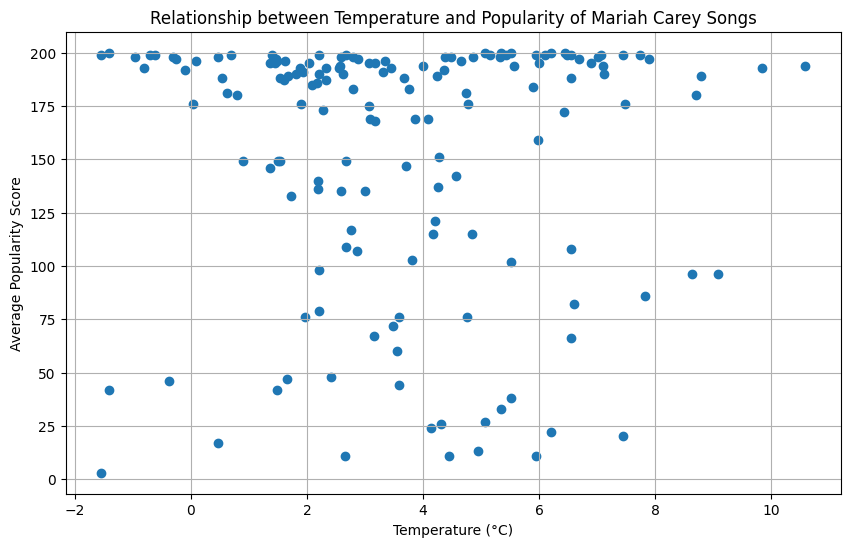

In [ ]:
mcarey_df = songs_df[songs_df["artist"].notna()]
mcarey_df = mcarey_df[mcarey_df["artist"].str.contains("Mariah Carey")]
mcarey_df["popularity_score"] = 201 - mcarey_df["position"]
small_temperature_df = temperature_df[["date", "lufttemperatur"]]

# Merge temperature_df and mcarey_df
merged_df = small_temperature_df.merge(mcarey_df, on="date")
merged_df.sort_values("popularity_score")

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(merged_df["lufttemperatur"], merged_df["popularity_score"], marker="o")
plt.xlabel("Temperature (°C)")
plt.ylabel("Average Popularity Score")
plt.title("Relationship between Temperature and Popularity of Mariah Carey Songs")
plt.grid(True)
plt.show()

#### Correlations

In [19]:
x_vars = list(audio_features_df.columns.values)
x_vars.remove("track_id")
x_vars.remove("mode")

In [20]:
def plot_lines(df: pd.DataFrame, title: str, n_bins: int = 20, order: int = 1):
    # Create bins
    df["bin"] = pd.cut(df[title], n_bins)
    bins = merged_df["bin"].cat.categories
    avg_values = [(bin.left + bin.right) / 2 for bin in bins]
    bin_counts = merged_df["bin"].value_counts().sort_index()
    print(f"Bin Counts:\n{bin_counts}")

    for var in x_vars:
        mean_feature_val_df = merged_df.groupby("bin")[var].mean().reset_index()
        # Plot the relationship between binned weather feature and mean audio feature value
        plt.figure(figsize=(10, 6))
        plt.plot(avg_values, mean_feature_val_df[var], marker="o")
        sns.regplot(x=avg_values, y=mean_feature_val_df[var], marker="o", color=".2", order=order, ci=90,)
        plt.xlabel(title)
        plt.ylabel(f"Average {var}")
        plt.title(f"Relationship between {title} and Mean {var} of Songs")
        plt.grid(True)
        plt.show()

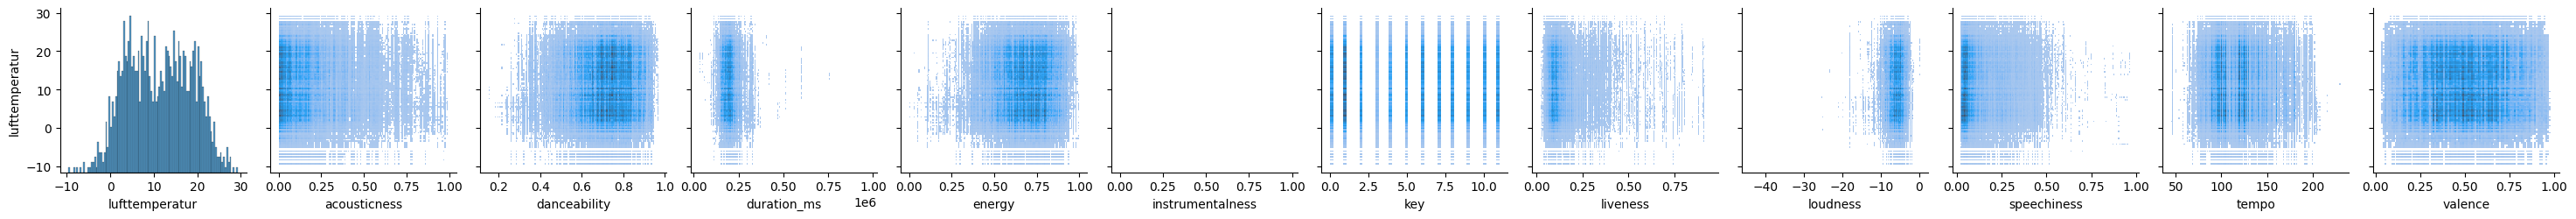

Bin Counts:
bin
(-9.654, -8.058]      400
(-8.058, -6.501]      400
(-6.501, -4.944]      400
(-4.944, -3.386]     1800
(-3.386, -1.829]     3000
(-1.829, -0.272]     4600
(-0.272, 1.285]     10200
(1.285, 2.842]      17000
(2.842, 4.4]        21000
(4.4, 5.957]        19600
(5.957, 7.514]      17800
(7.514, 9.071]      20800
(9.071, 10.629]     15200
(10.629, 12.186]    14600
(12.186, 13.743]    17999
(13.743, 15.3]      18600
(15.3, 16.857]      18600
(16.857, 18.415]    16200
(18.415, 19.972]    17800
(19.972, 21.529]    17400
(21.529, 23.086]    10400
(23.086, 24.643]     6000
(24.643, 26.201]     2600
(26.201, 27.758]     1600
(27.758, 29.315]     1000
Name: count, dtype: int64


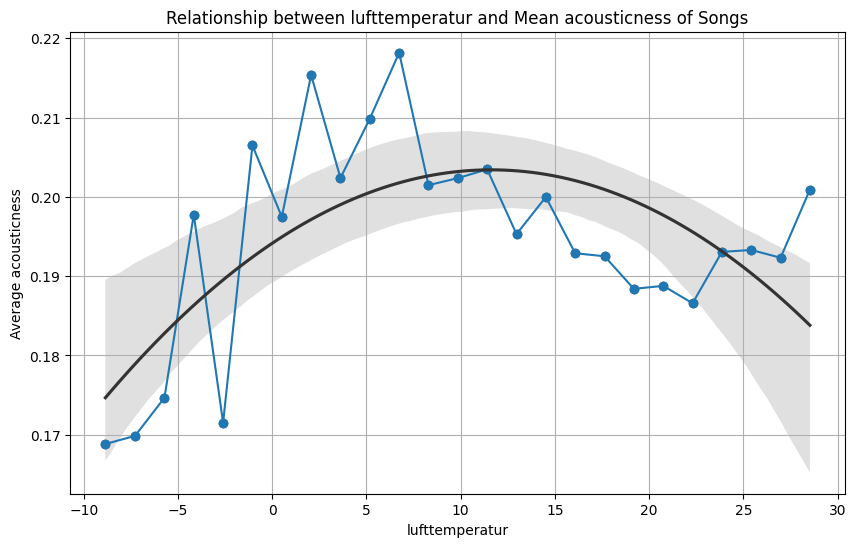

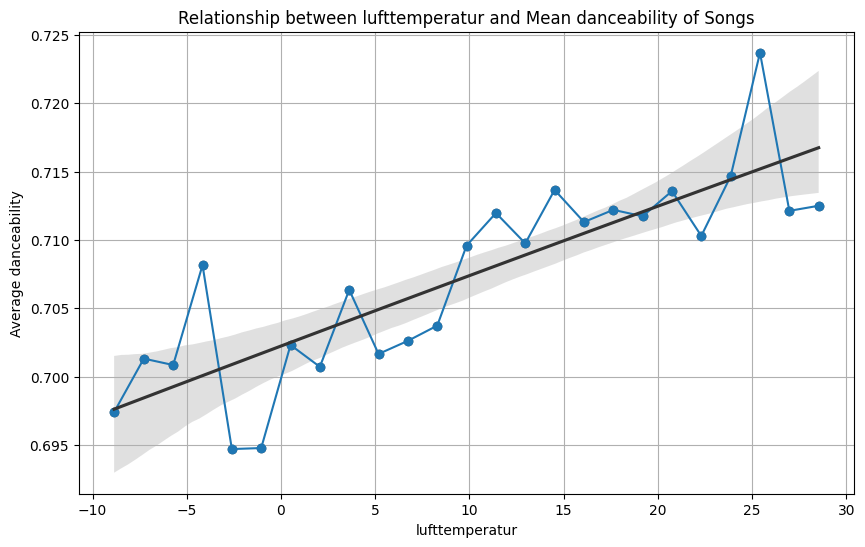

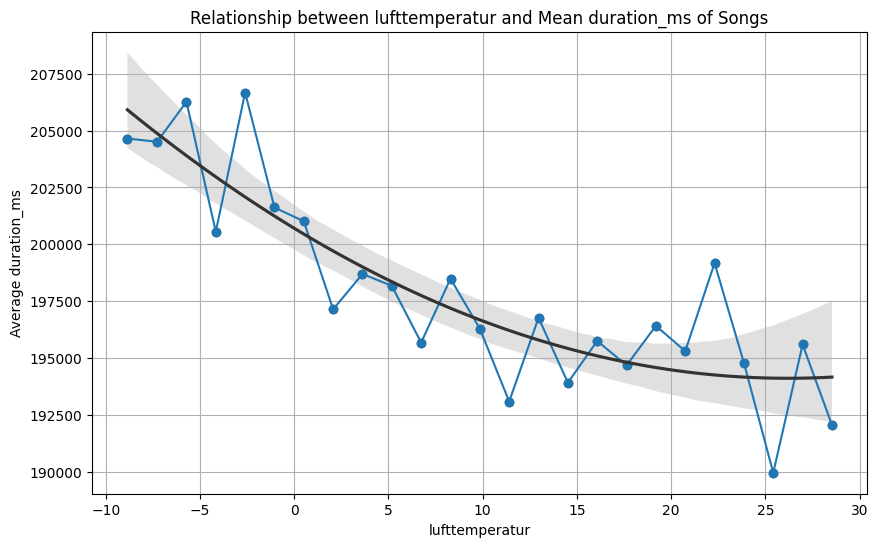

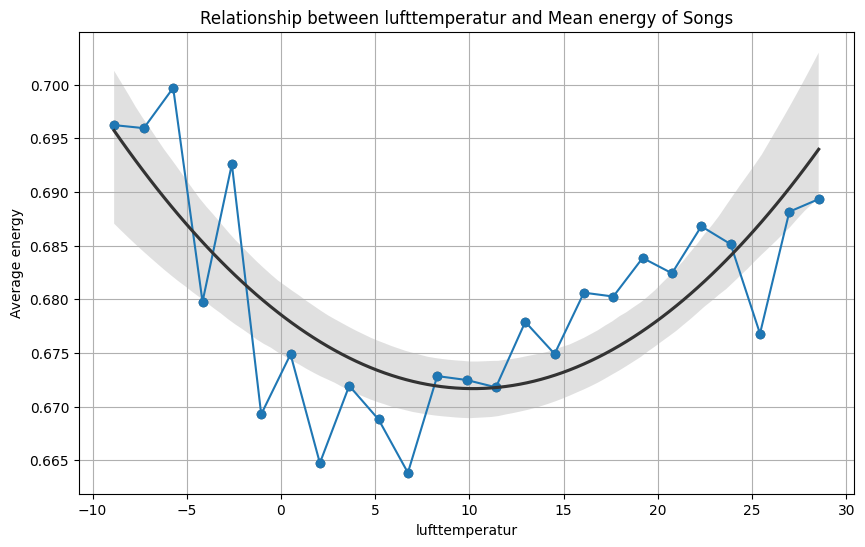

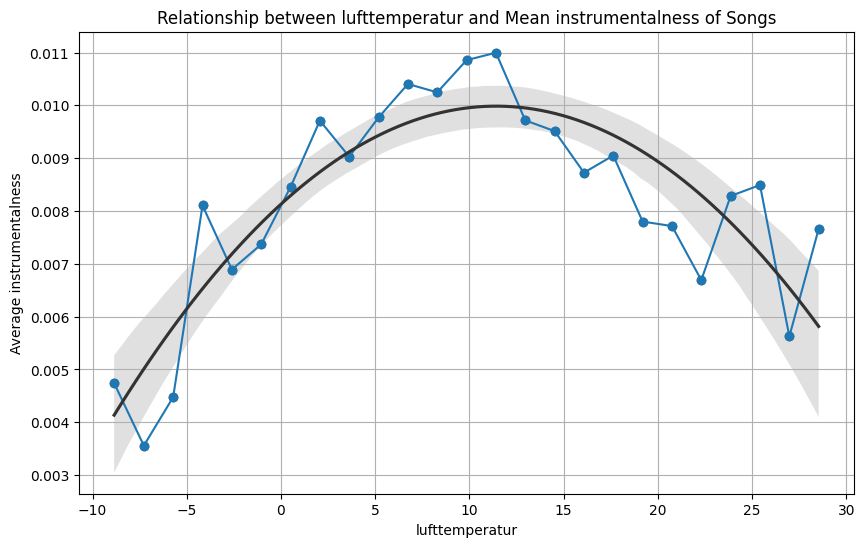

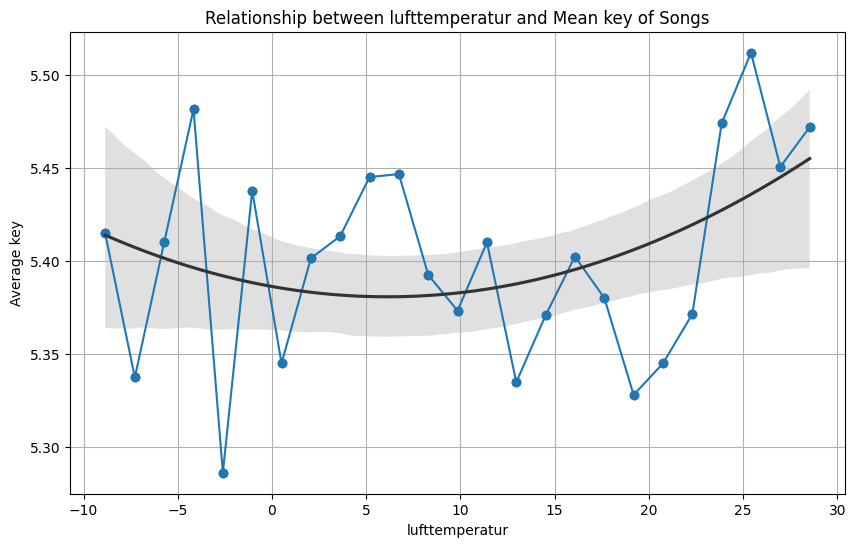

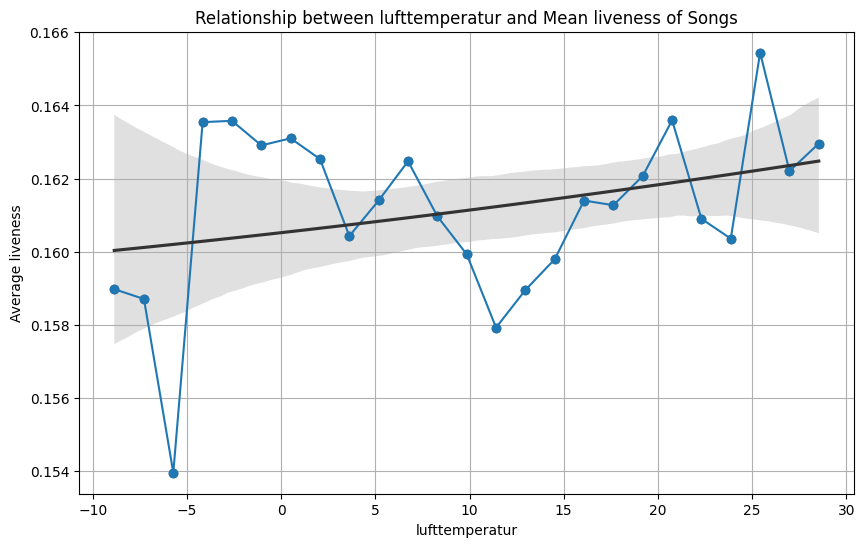

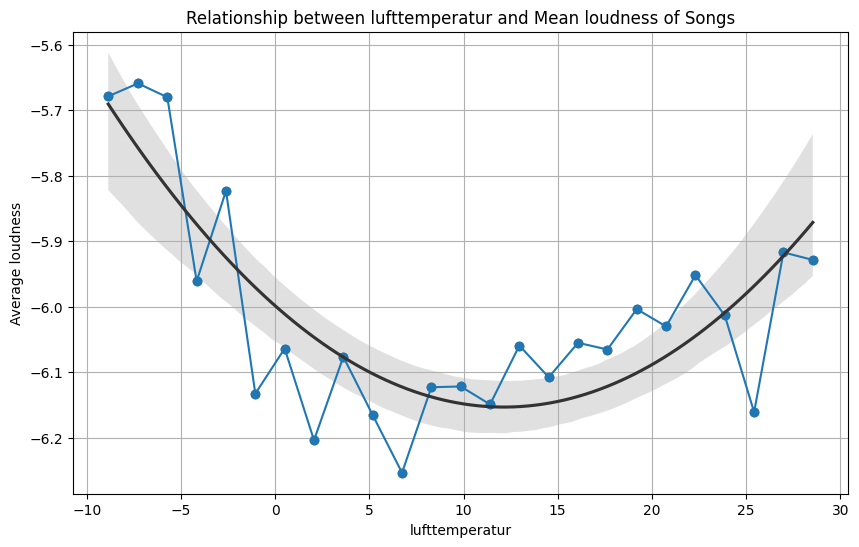

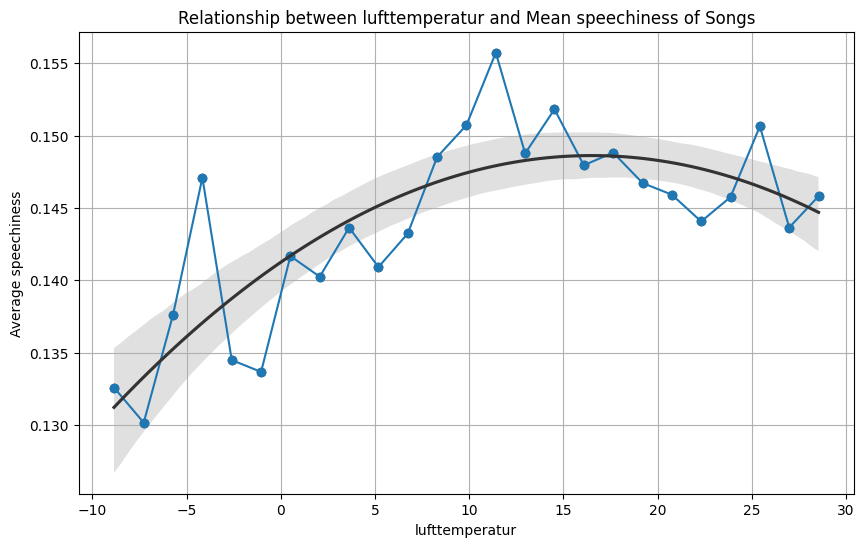

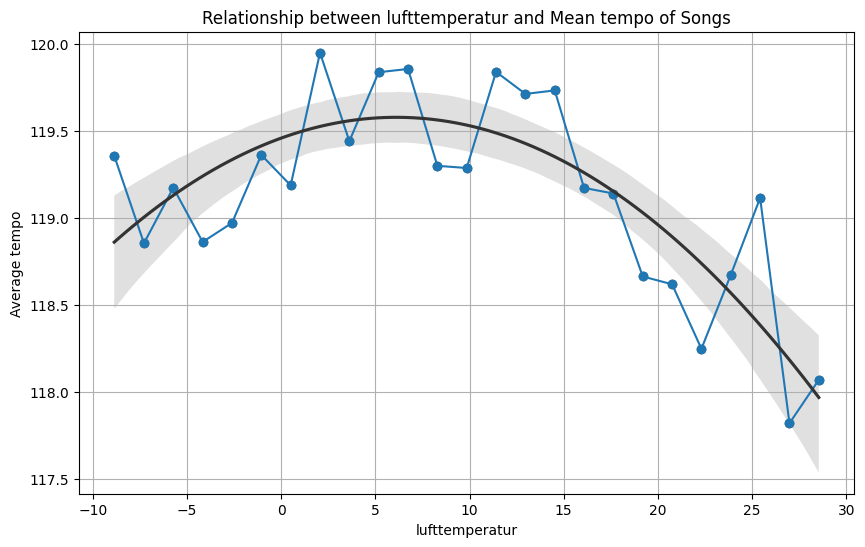

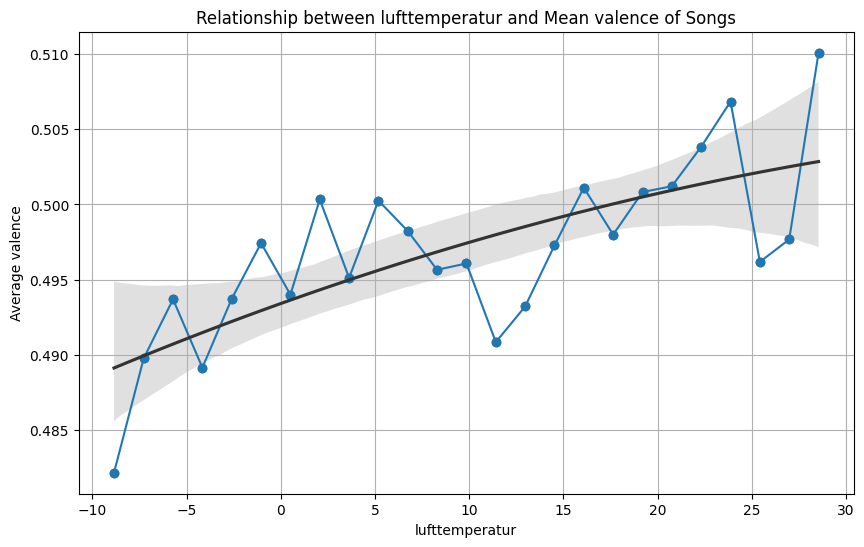

In [21]:
merged_df = temperature_df[["date", "lufttemperatur"]]
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")
sns.pairplot(merged_df, kind="hist", x_vars=["lufttemperatur"] + x_vars,
             y_vars=["lufttemperatur"])  # kinds: ‘scatter’, ‘kde’, ‘hist’, ‘reg’
plt.show()
plot_lines(merged_df, "lufttemperatur", 25, 2)

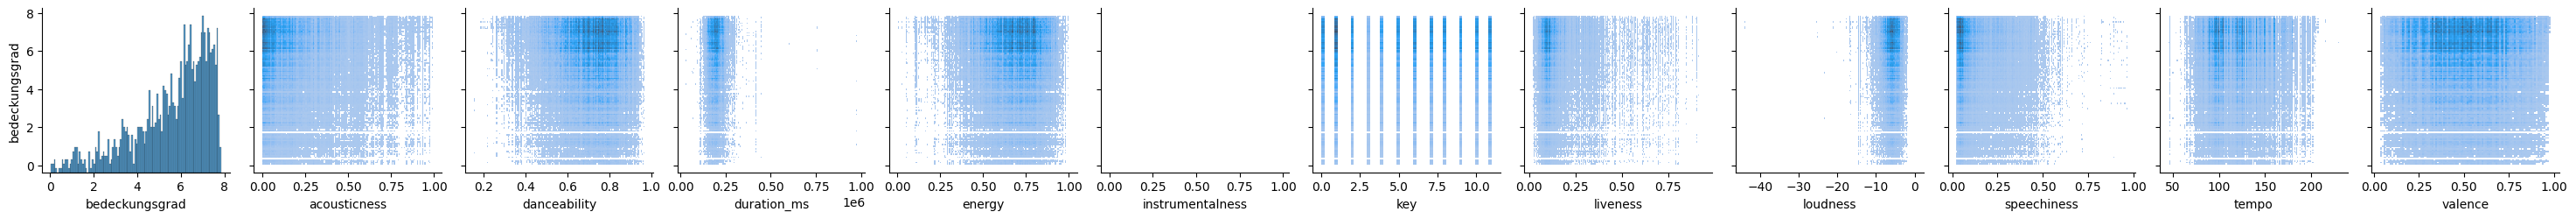

Bin Counts:
bin
(0.0128, 0.412]     1800
(0.412, 0.804]      2200
(0.804, 1.196]      4000
(1.196, 1.587]      3600
(1.587, 1.979]      2200
(1.979, 2.37]       5600
(2.37, 2.762]       4800
(2.762, 3.154]      6200
(3.154, 3.545]     10200
(3.545, 3.937]      7600
(3.937, 4.329]     10200
(4.329, 4.72]      13600
(4.72, 5.112]      15800
(5.112, 5.503]     18400
(5.503, 5.895]     18400
(5.895, 6.287]     27999
(6.287, 6.678]     30400
(6.678, 7.07]      33800
(7.07, 7.462]      34200
(7.462, 7.853]     24000
Name: count, dtype: int64


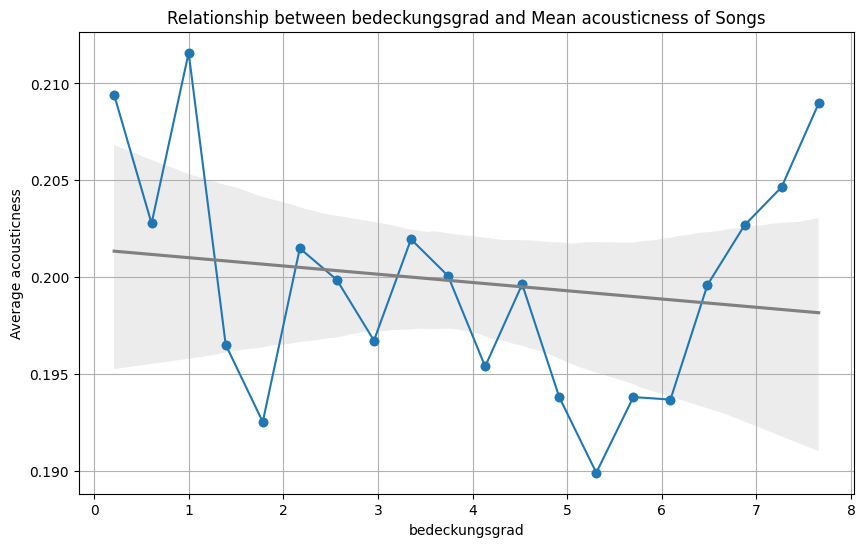

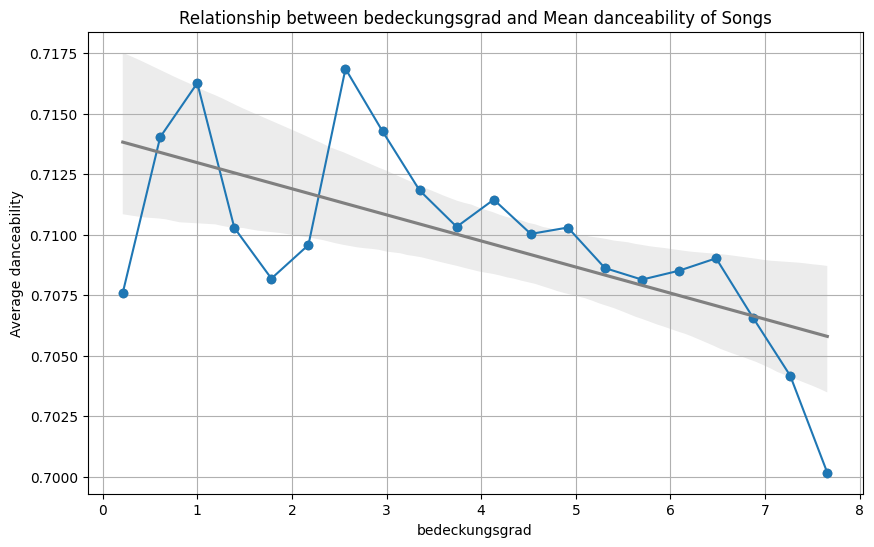

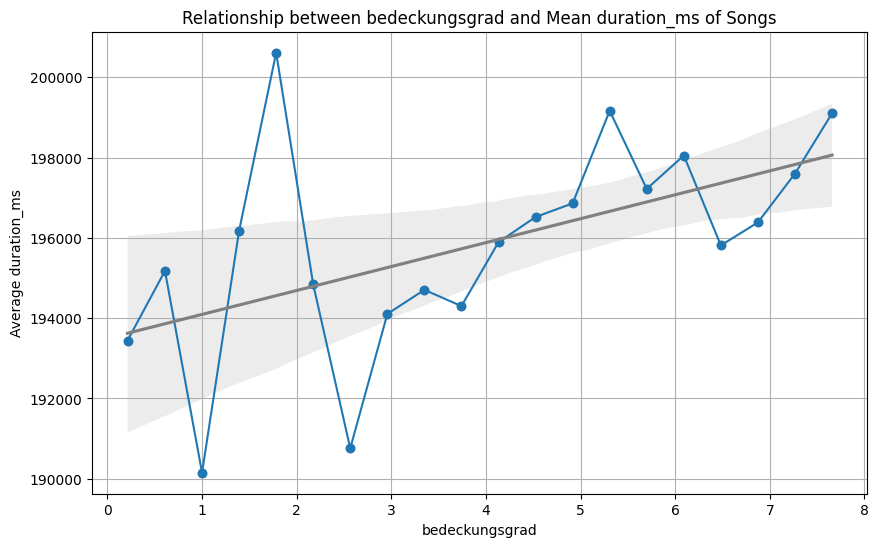

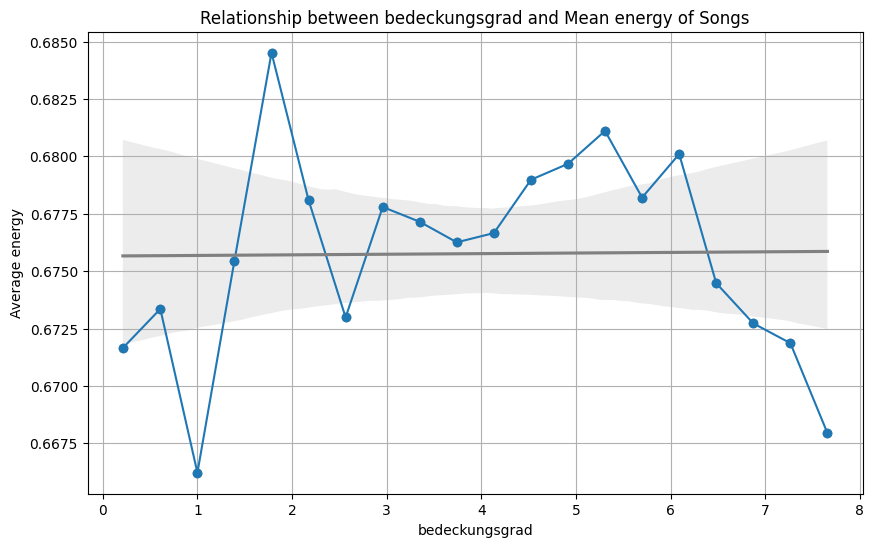

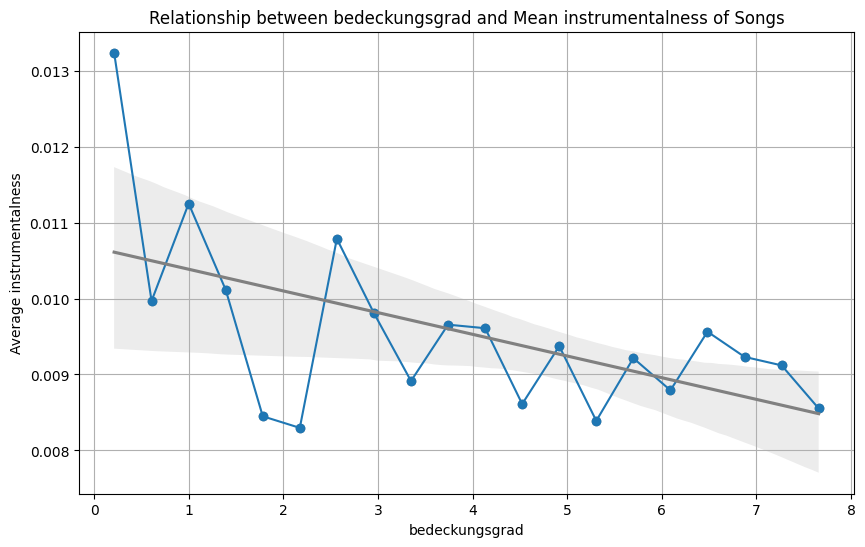

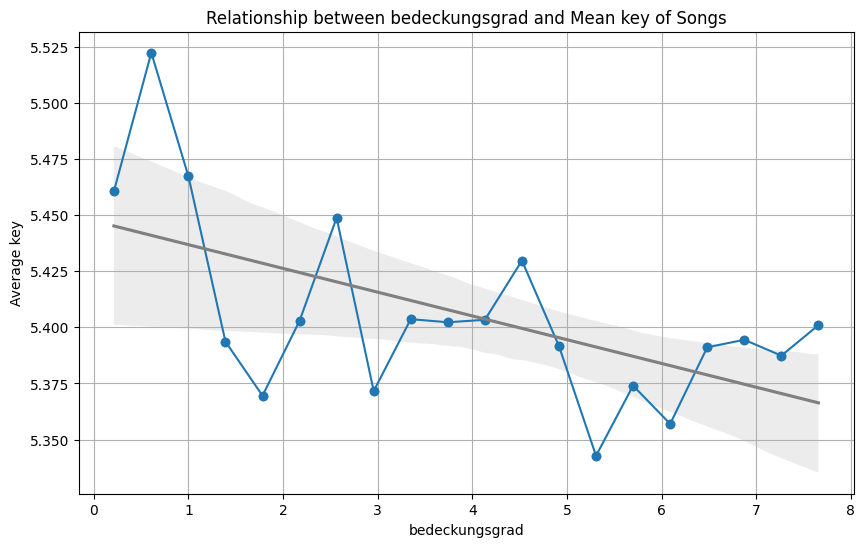

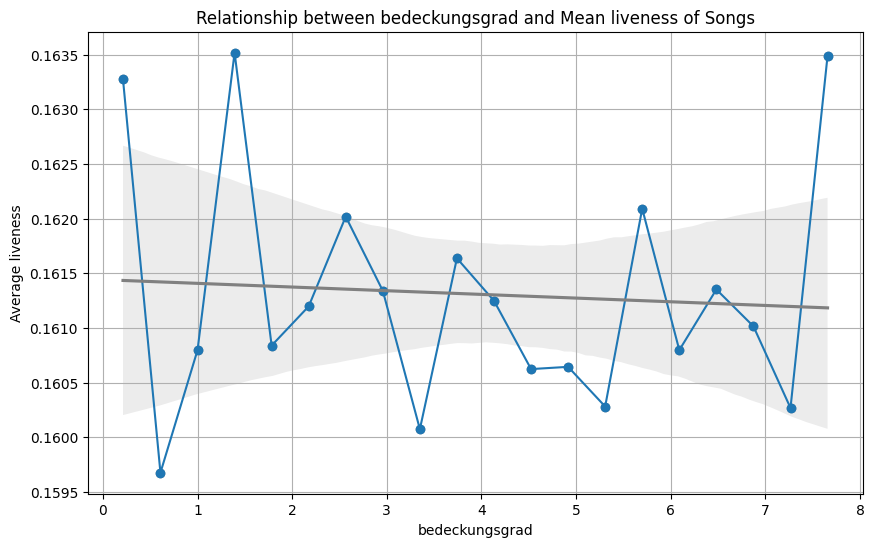

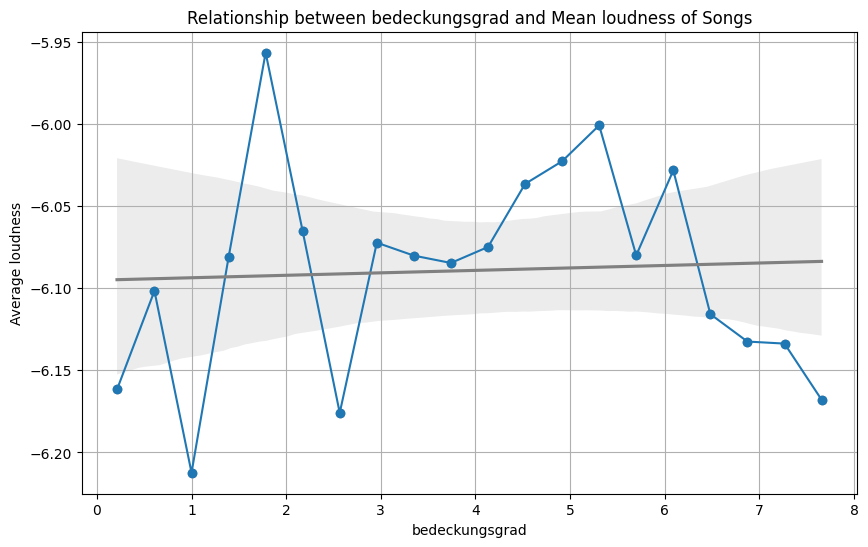

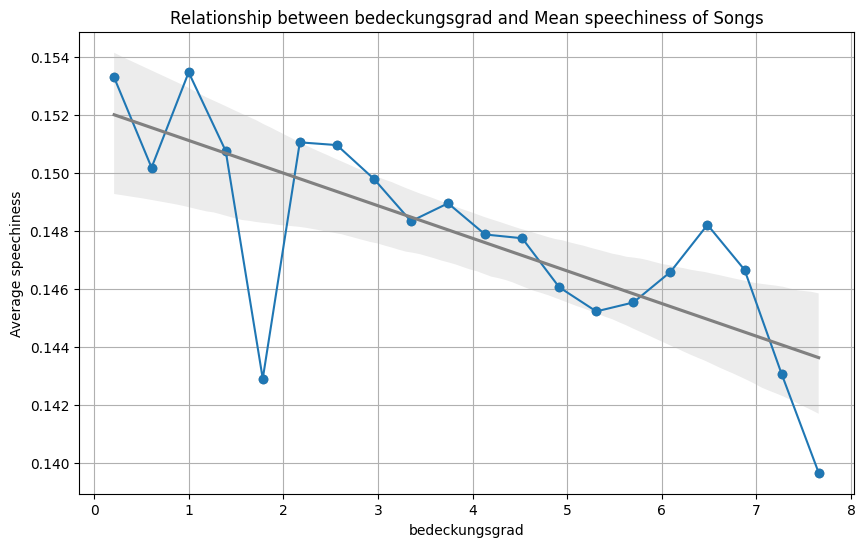

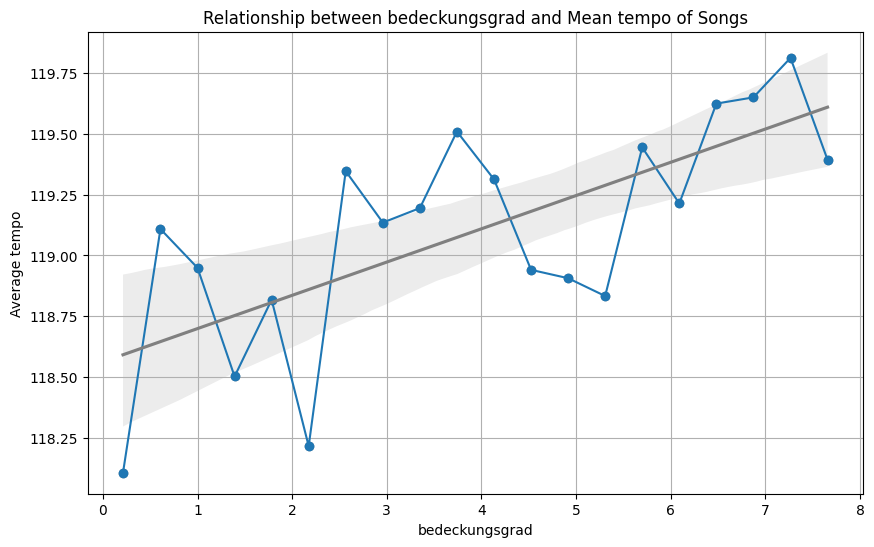

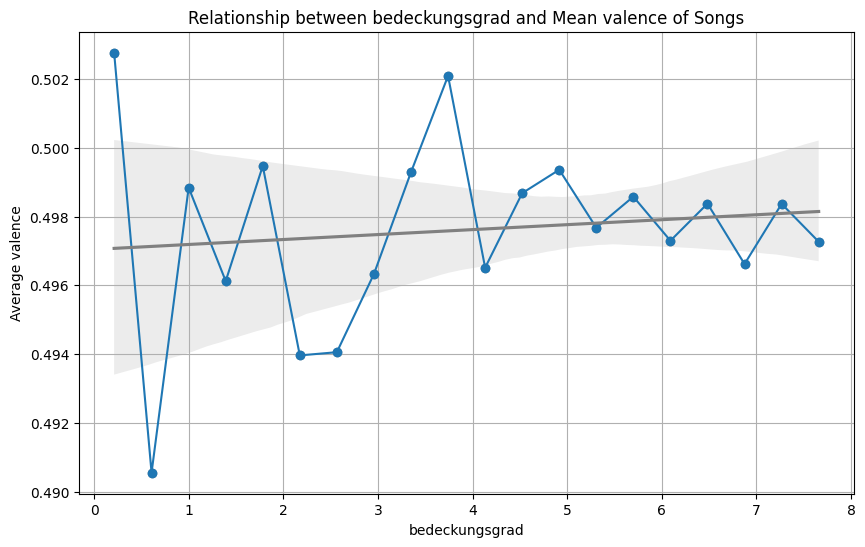

In [22]:
merged_df = cloud_df
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")
sns.pairplot(merged_df, kind="hist", x_vars=["bedeckungsgrad"] + x_vars, y_vars=["bedeckungsgrad"])
plt.show()
plot_lines(merged_df, "bedeckungsgrad")

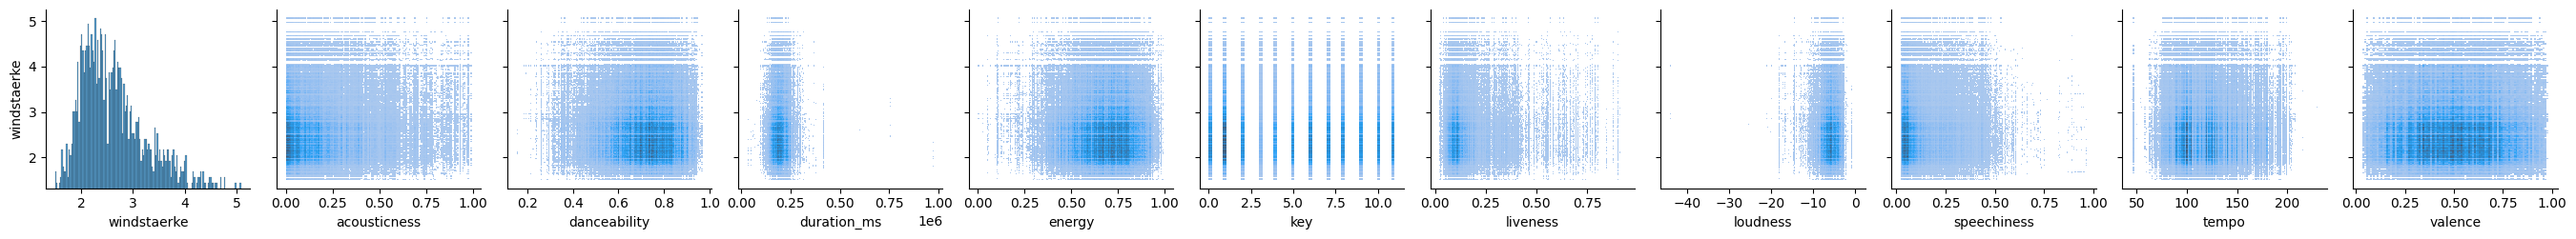

Bin Counts:
bin
(1.498, 1.68]      4000
(1.68, 1.859]      9800
(1.859, 2.038]    29600
(2.038, 2.217]    37600
(2.217, 2.396]    37600
(2.396, 2.575]    29999
(2.575, 2.753]    33200
(2.753, 2.932]    23600
(2.932, 3.111]    18200
(3.111, 3.29]     11200
(3.29, 3.469]      9800
(3.469, 3.648]     9200
(3.648, 3.827]     8000
(3.827, 4.005]     5000
(4.005, 4.184]     2400
(4.184, 4.363]     2400
(4.363, 4.542]     1600
(4.542, 4.721]     1000
(4.721, 4.9]        400
(4.9, 5.079]        400
Name: count, dtype: int64


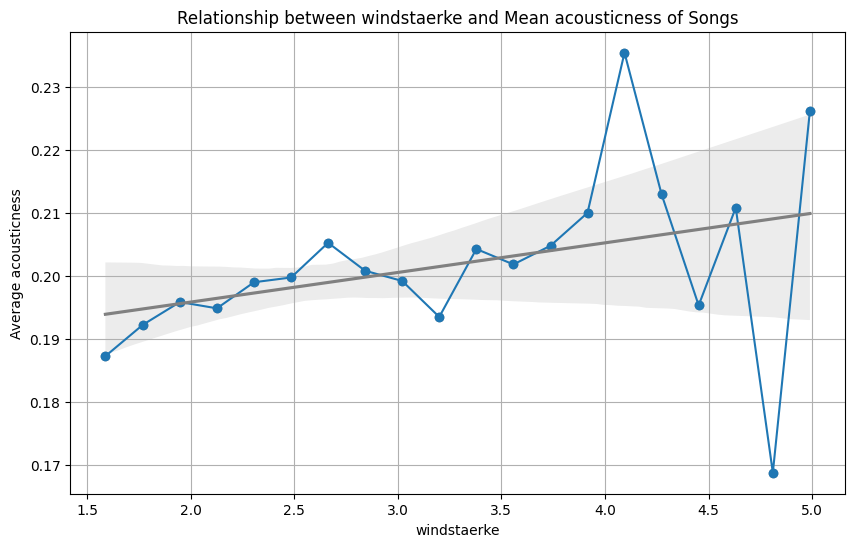

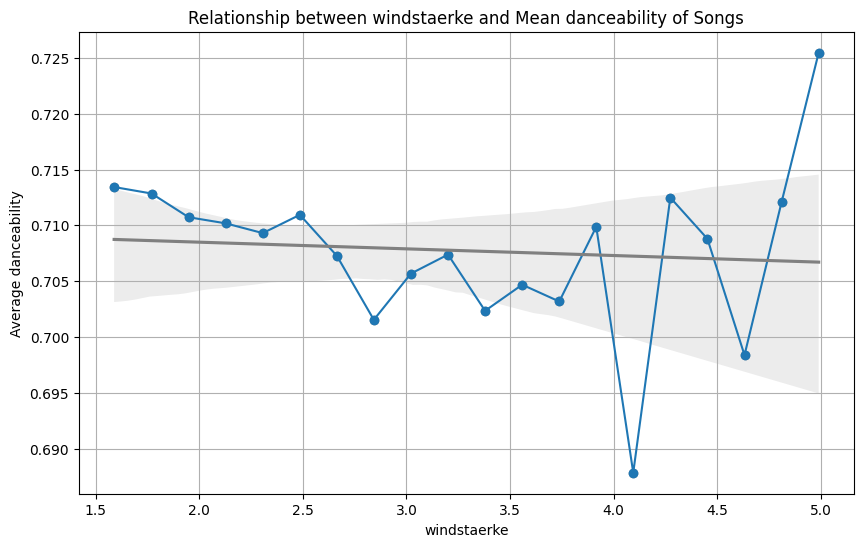

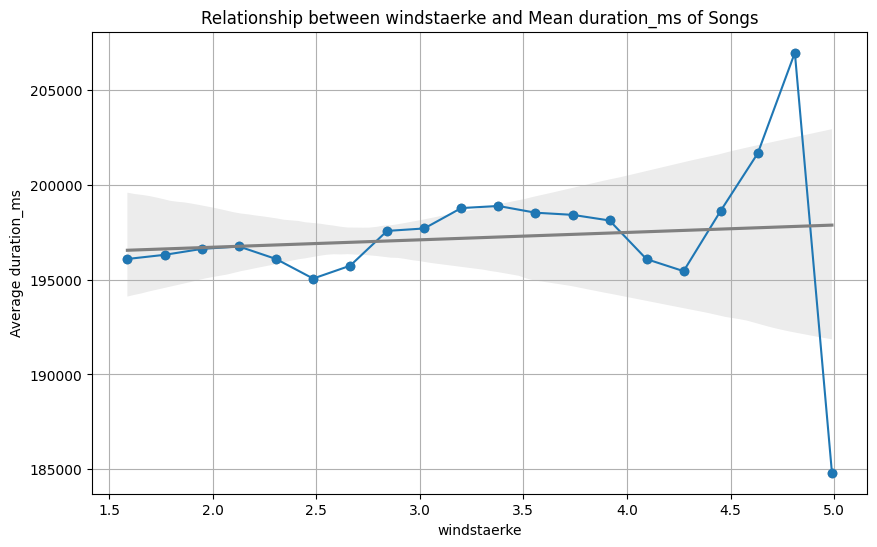

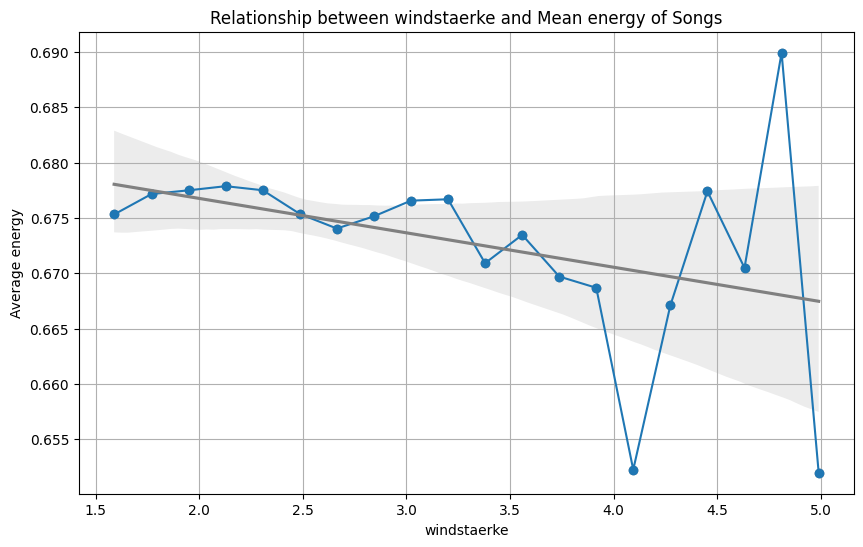

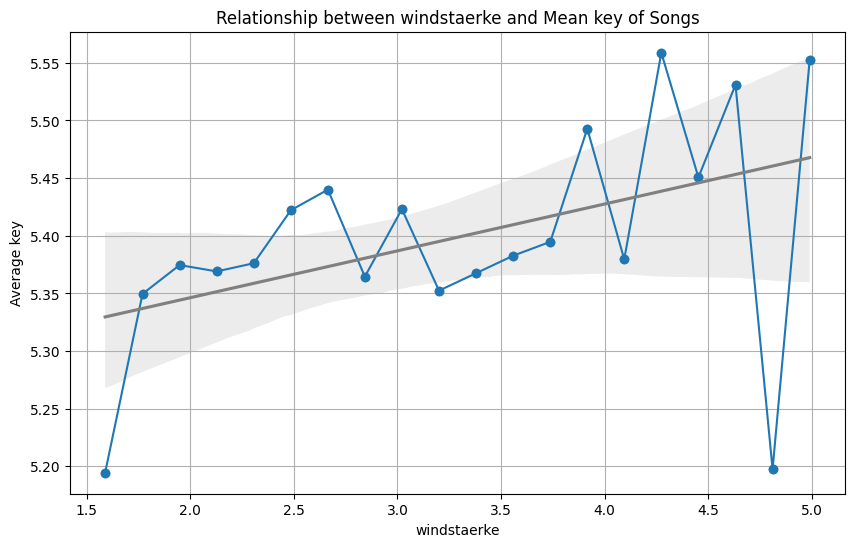

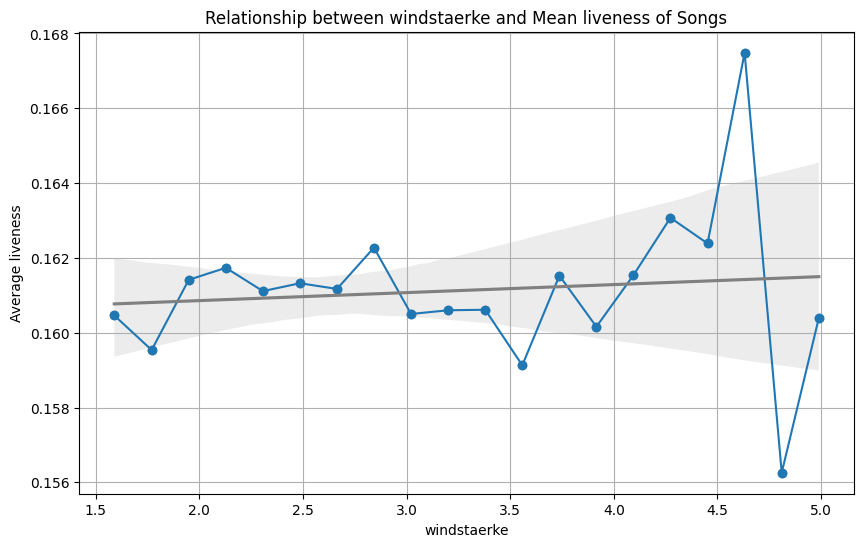

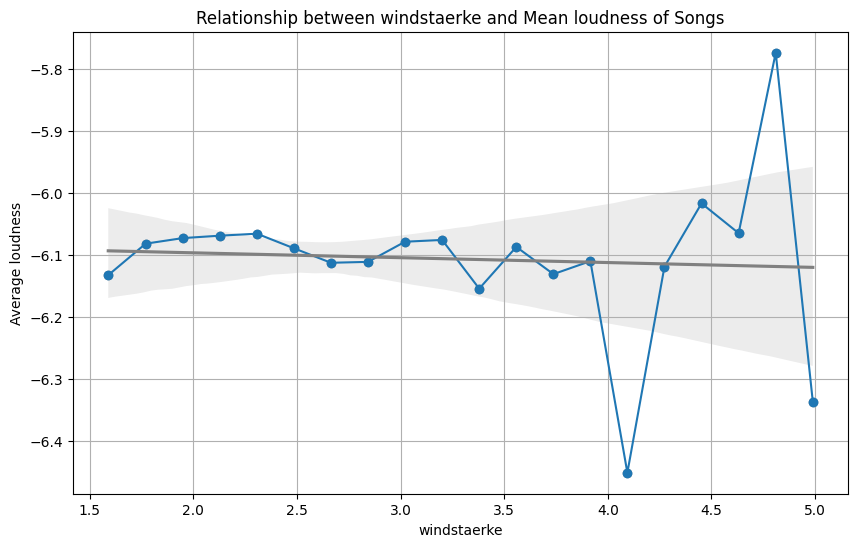

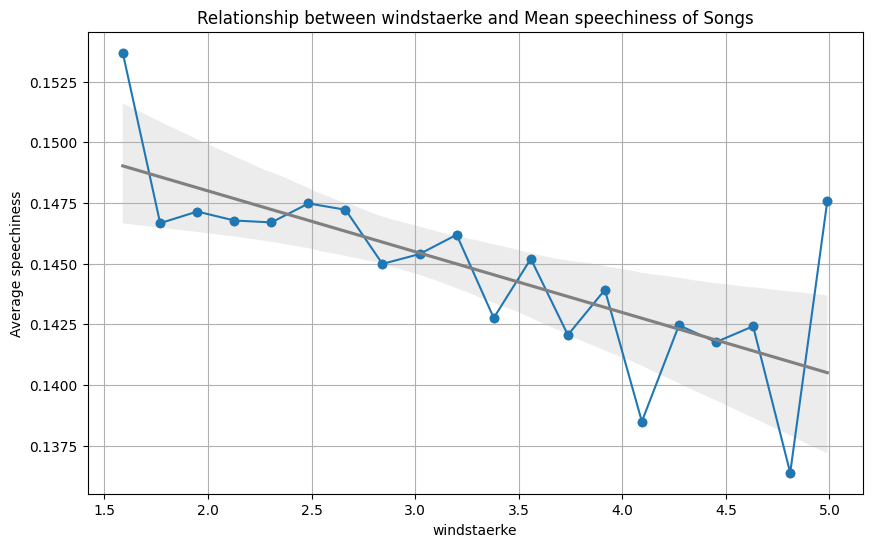

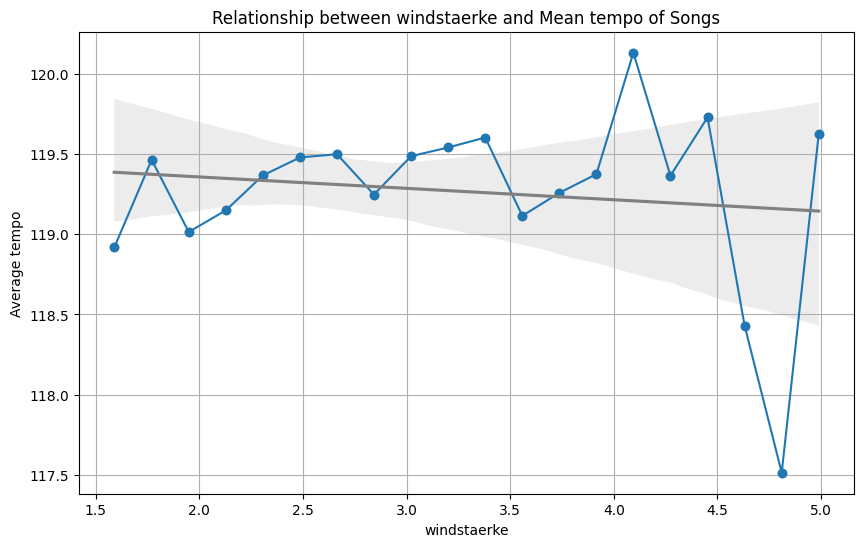

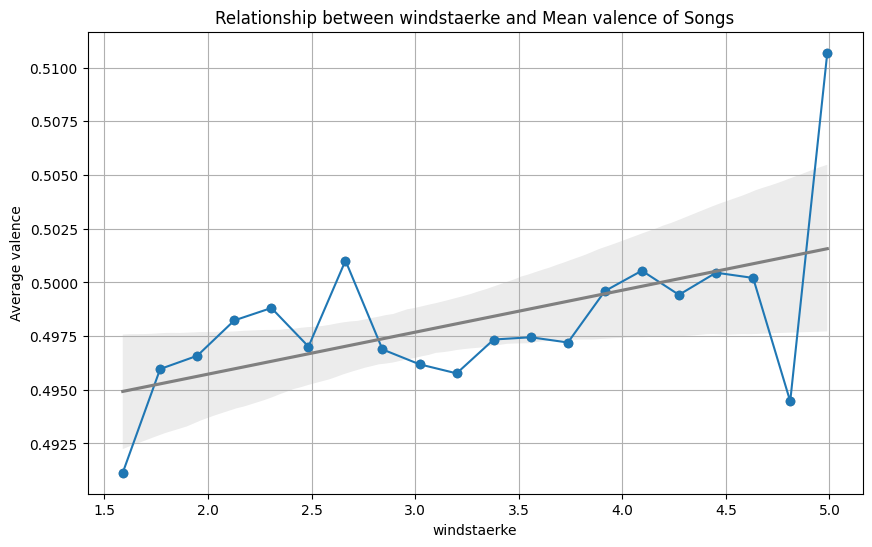

In [ ]:
merged_df = wind_df
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")
sns.pairplot(merged_df, kind="hist", x_vars=["windstaerke"] + x_vars, y_vars=["windstaerke"])
plt.show()
plot_lines(merged_df, "windstaerke")

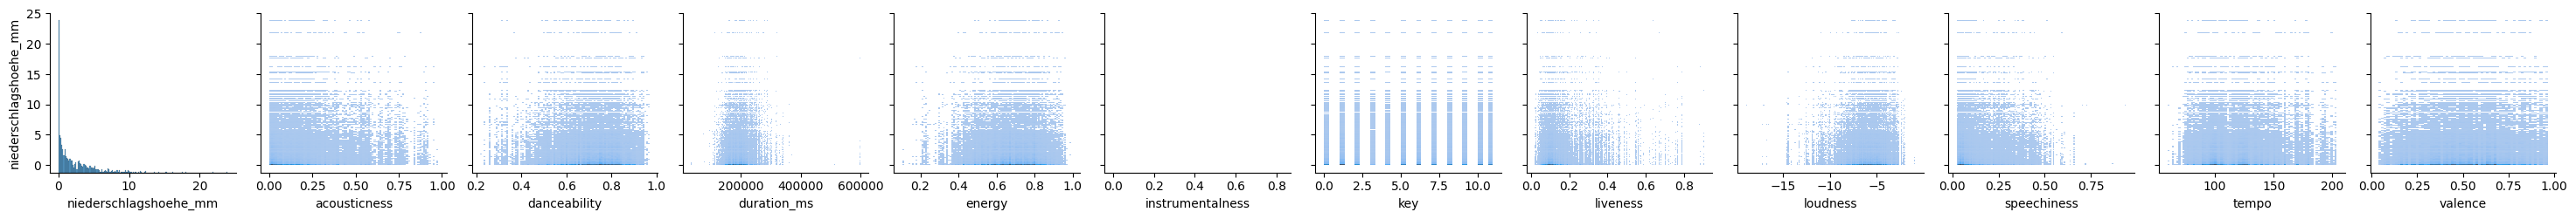

Bin Counts:
bin
(-0.0141, 1.183]    36500
(1.183, 2.366]       9750
(2.366, 3.549]       7600
(3.549, 4.732]       5350
(4.732, 5.916]       3200
(5.916, 7.099]       1500
(7.099, 8.282]       1350
(8.282, 9.465]        850
(9.465, 10.648]       850
(10.648, 11.831]      500
(11.831, 13.014]      250
(13.014, 14.197]      100
Name: count, dtype: int64


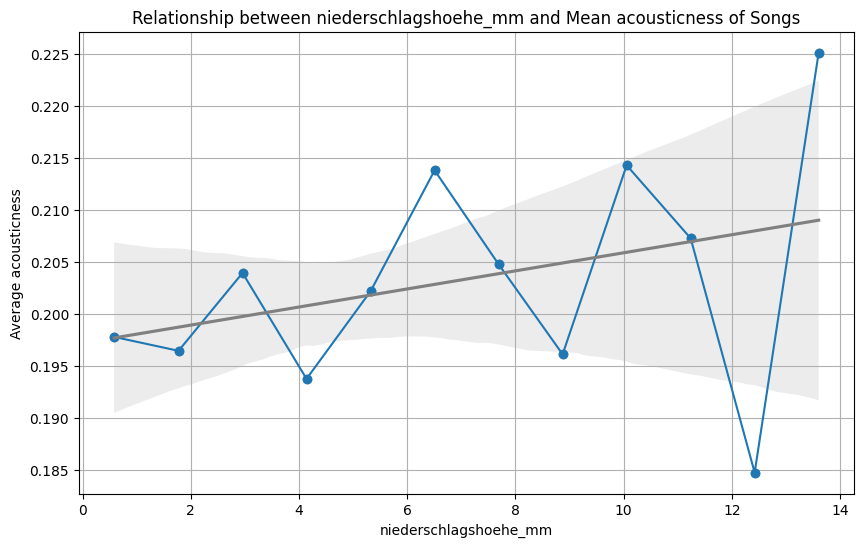

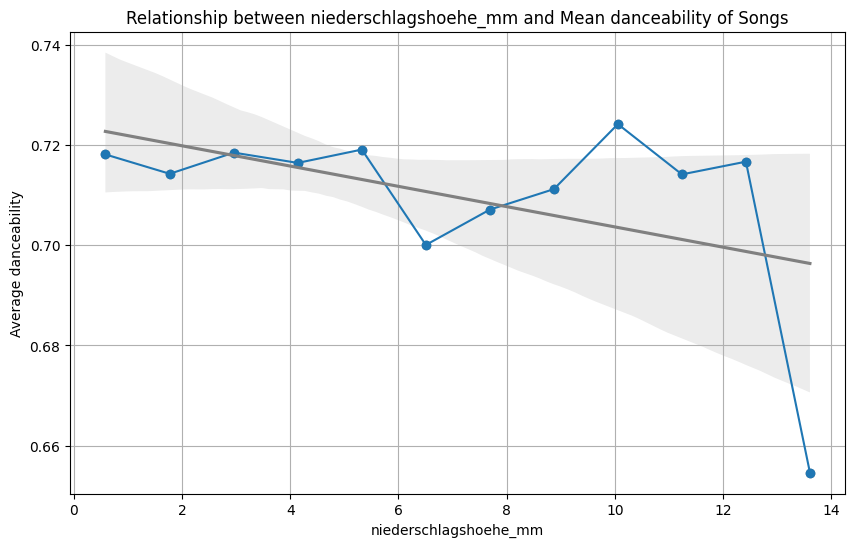

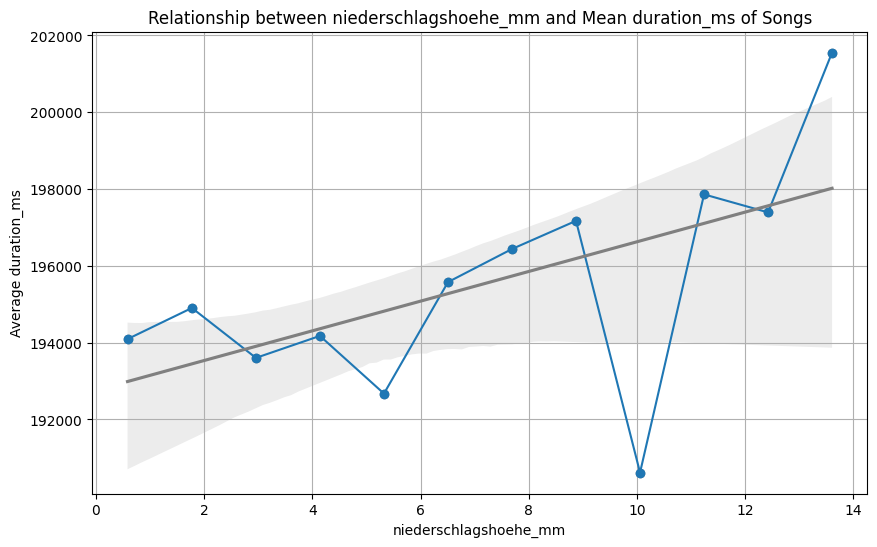

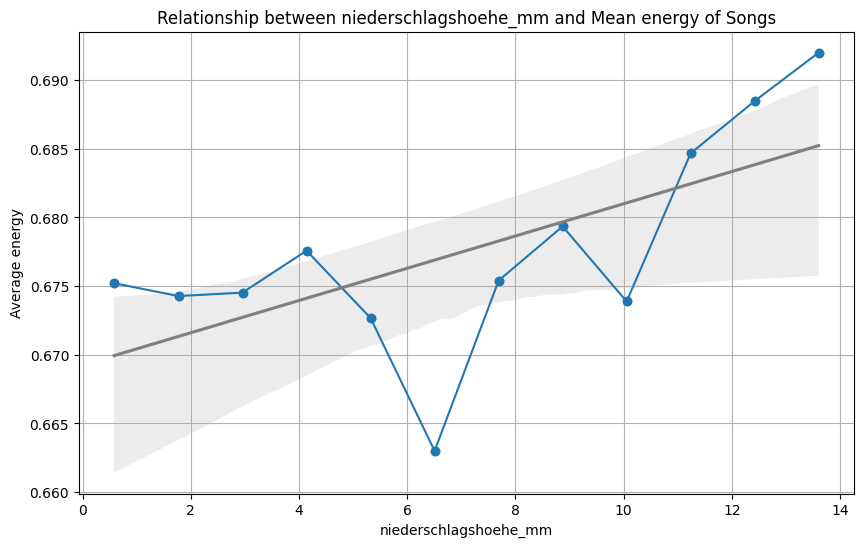

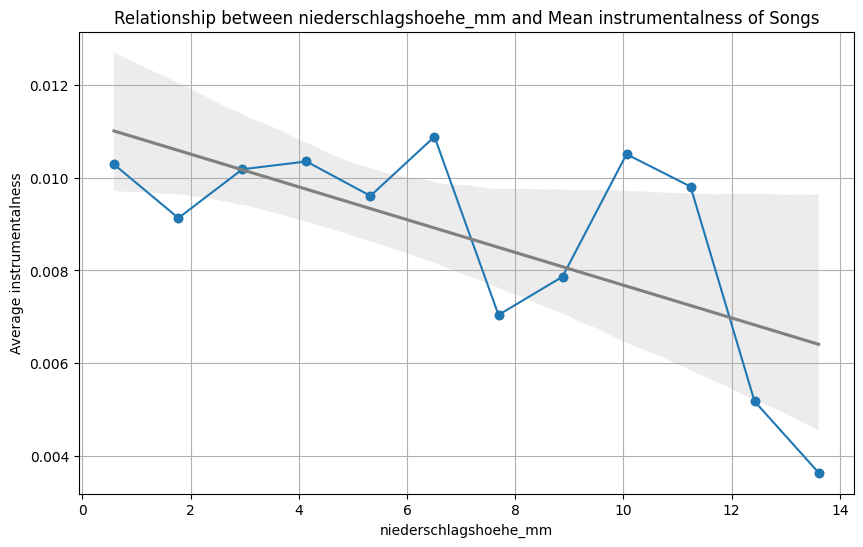

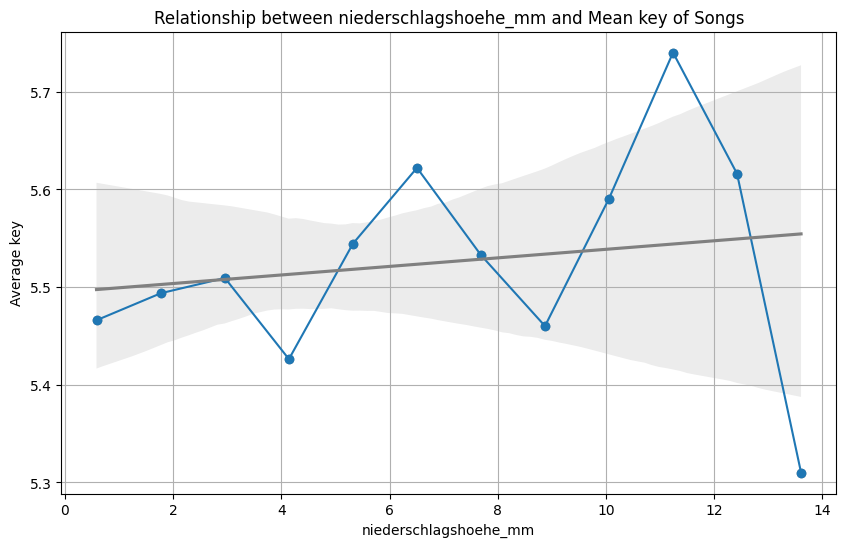

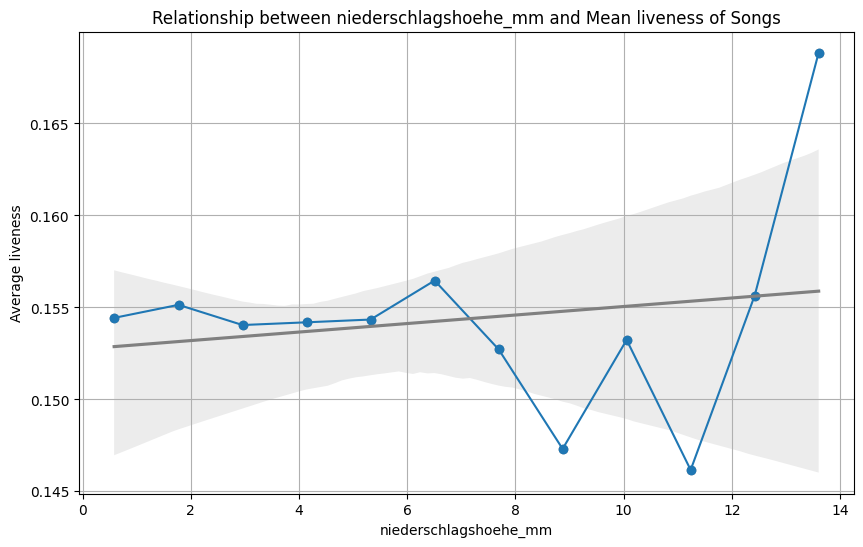

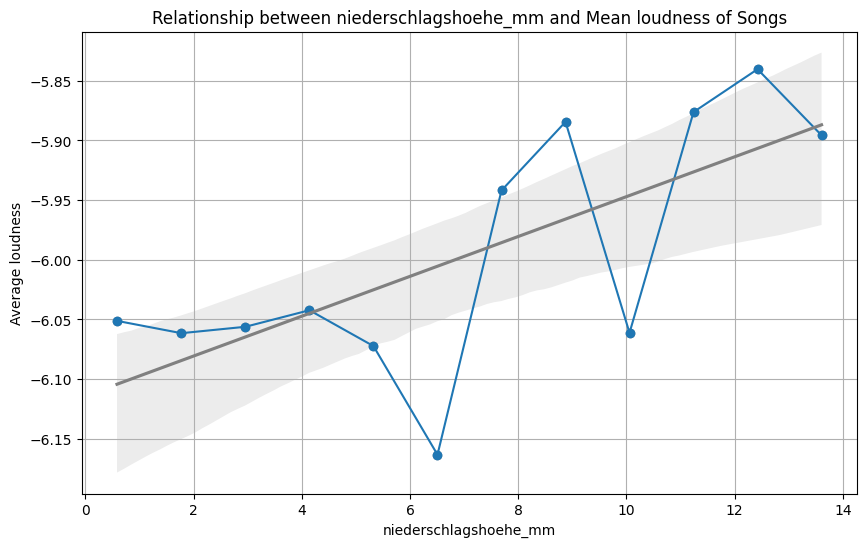

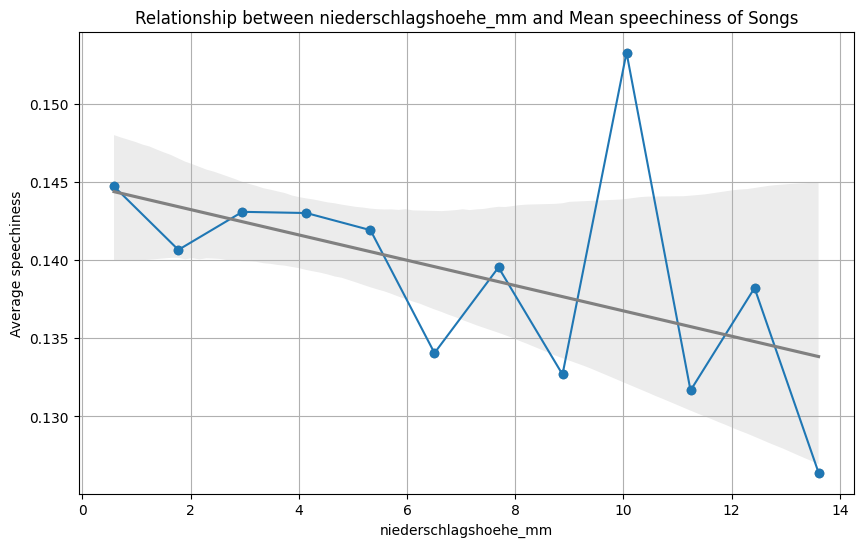

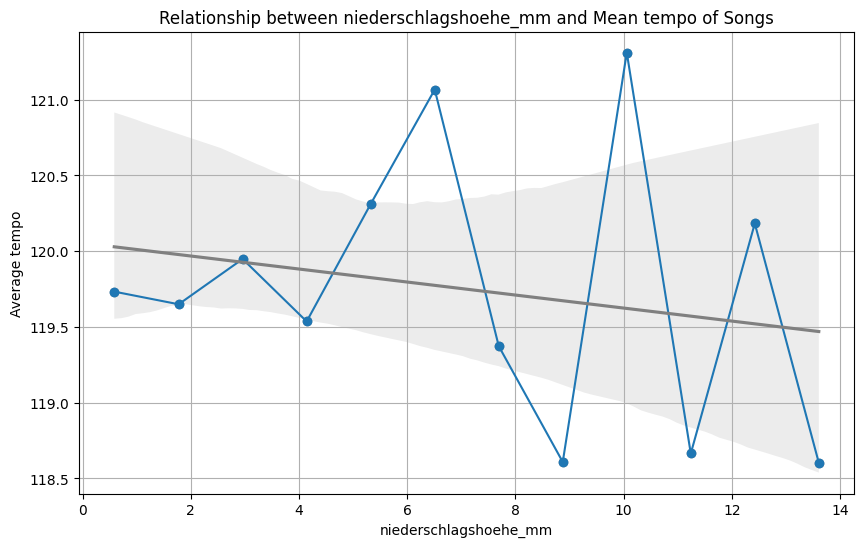

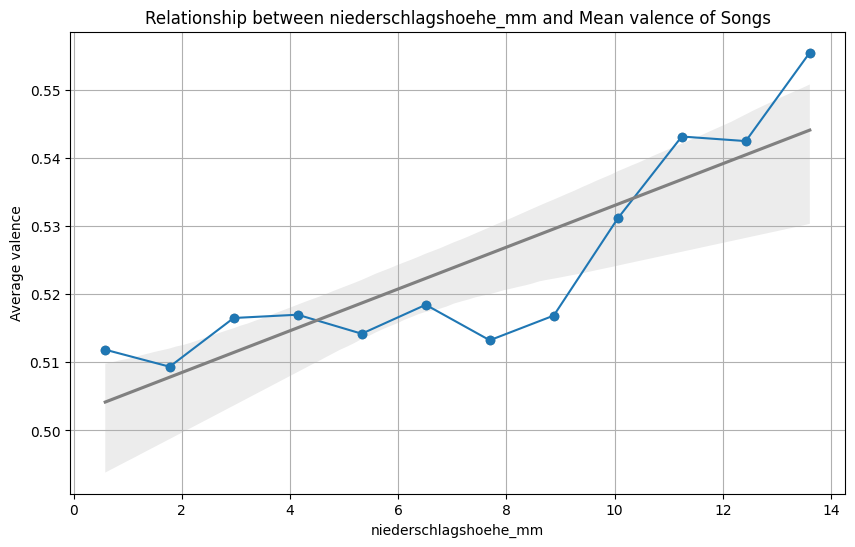

In [ ]:
merged_df = rain_df
merged_df = merged_df.merge(songs_df[songs_df["position"] <= 50], on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")
merged_df = merged_df[merged_df["niederschlagshoehe_mm"] > 0]
sns.pairplot(merged_df, kind="hist", x_vars=["niederschlagshoehe_mm"] + x_vars, y_vars=["niederschlagshoehe_mm"])
plt.show()
merged_df = merged_df[merged_df["niederschlagshoehe_mm"] <= 15]
plot_lines(merged_df, "niederschlagshoehe_mm", 12)

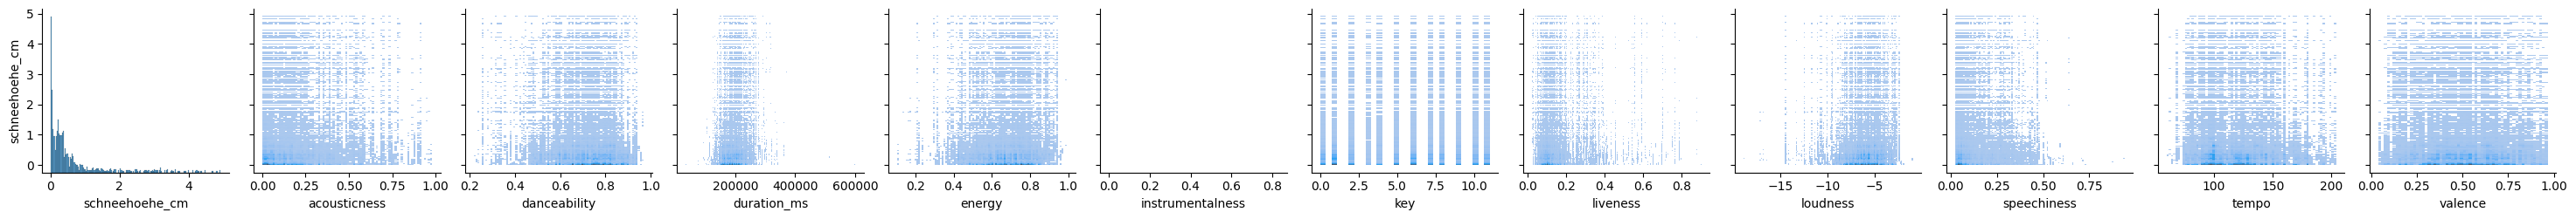

Bin Counts:
bin
(-0.00382, 0.329]    30400
(0.329, 0.657]       11750
(0.657, 0.985]        4100
(0.985, 1.313]        1650
(1.313, 1.642]        1300
(1.642, 1.97]         1000
(1.97, 2.298]          850
(2.298, 2.626]         650
(2.626, 2.954]         650
(2.954, 3.282]         950
(3.282, 3.61]          600
(3.61, 3.938]          450
(3.938, 4.266]         350
(4.266, 4.594]         300
(4.594, 4.923]         250
Name: count, dtype: int64


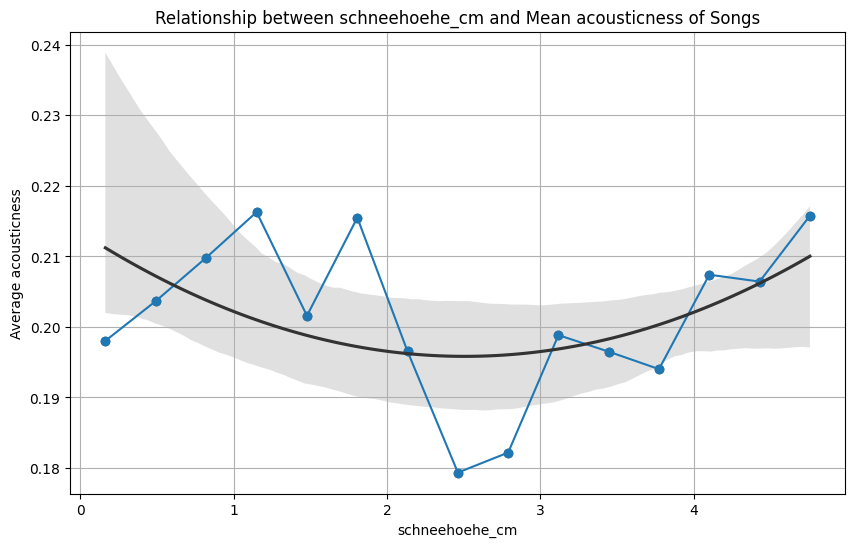

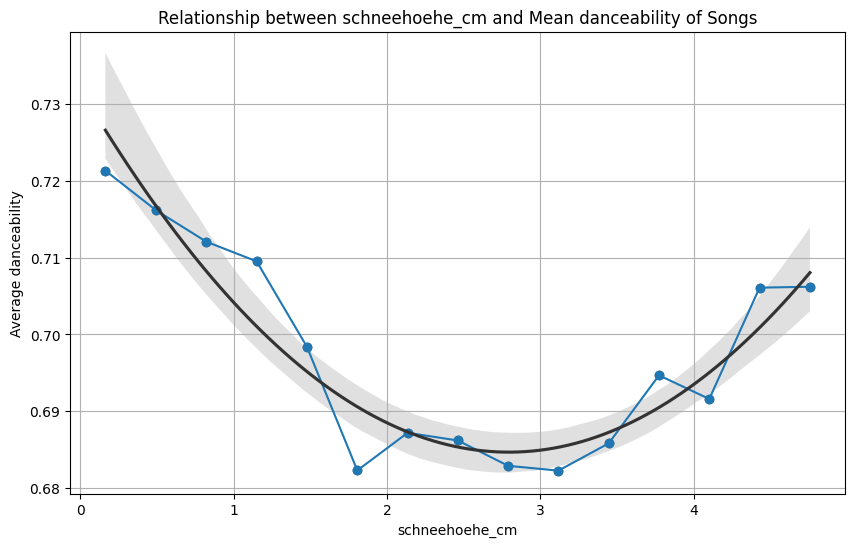

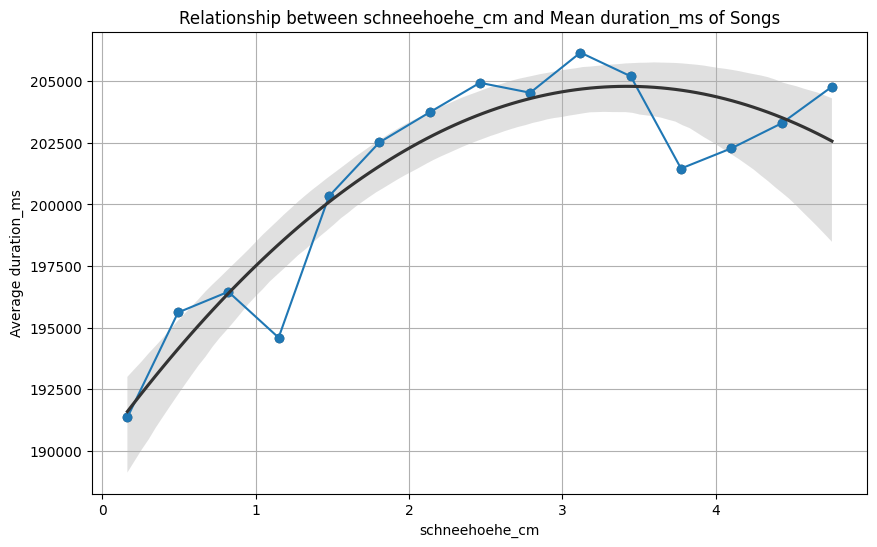

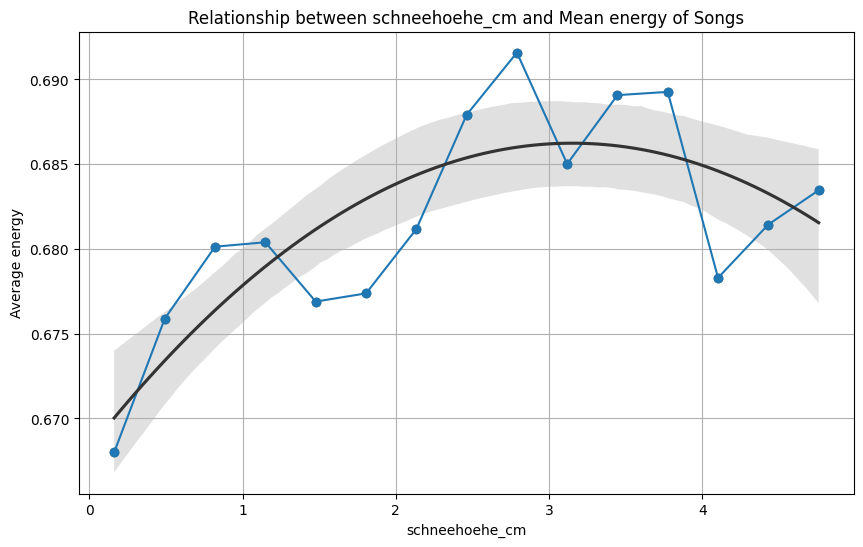

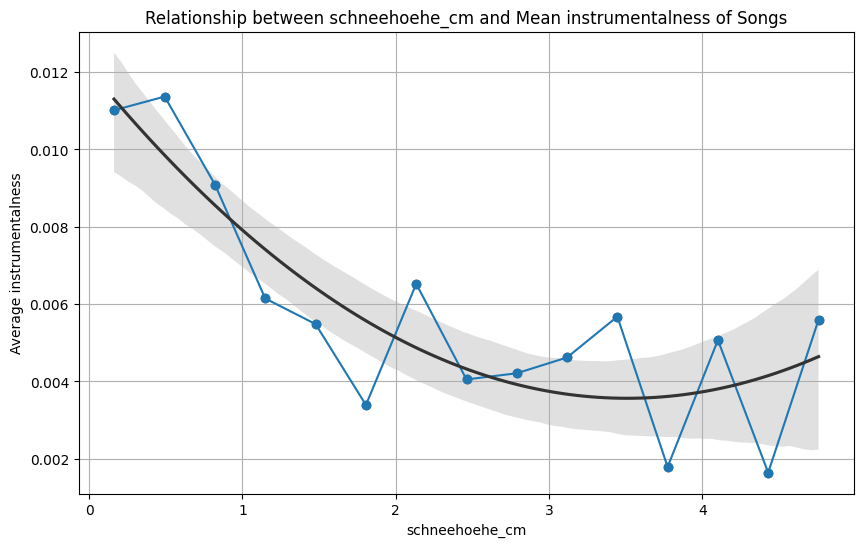

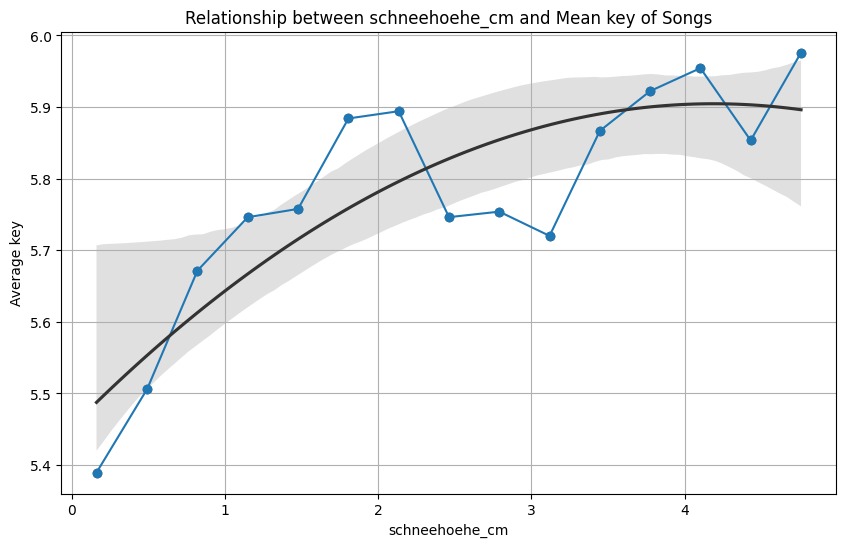

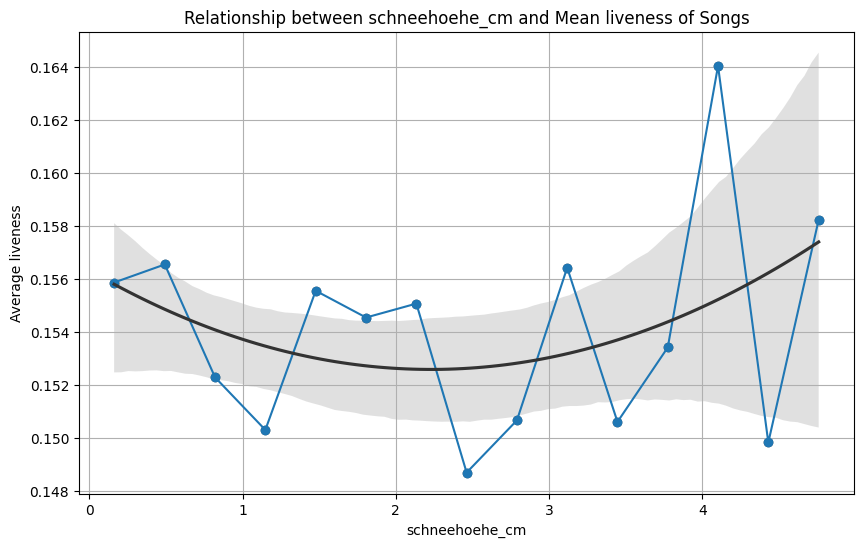

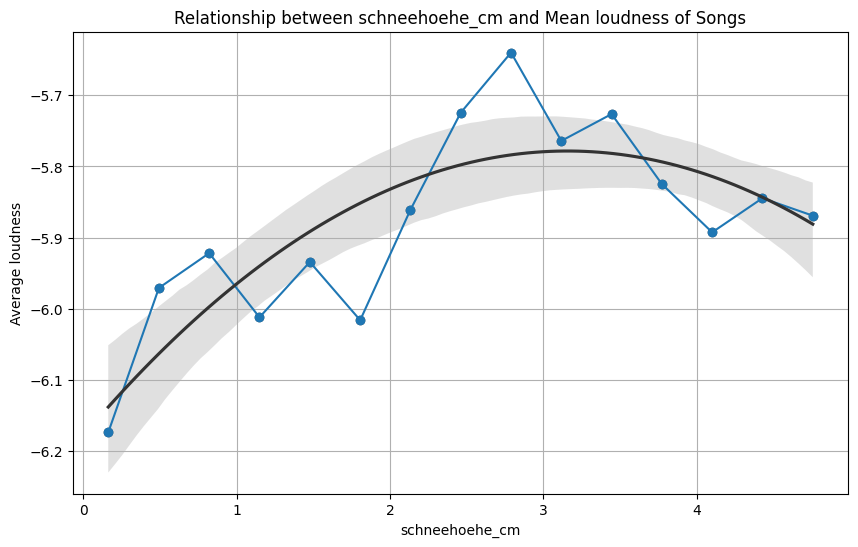

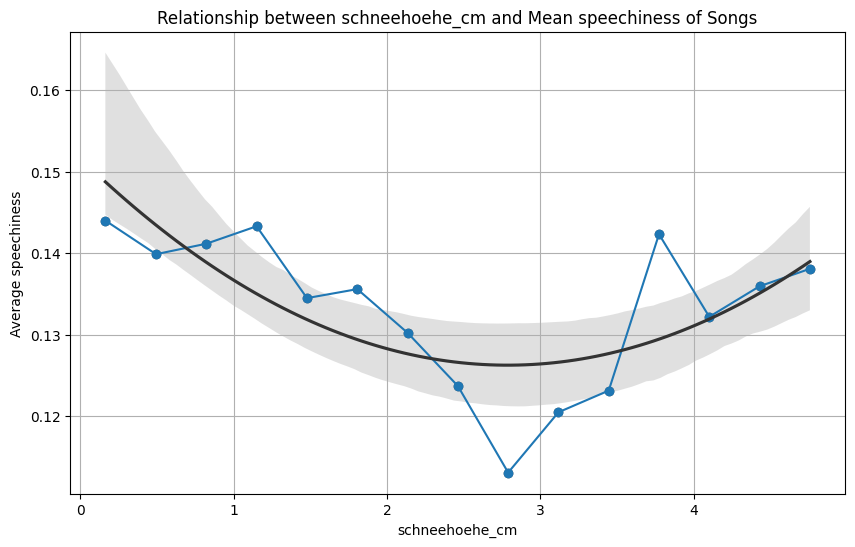

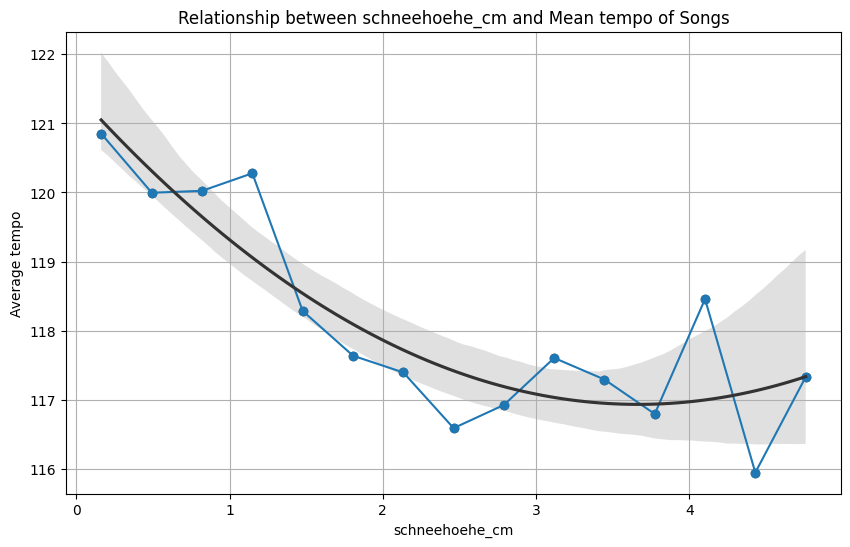

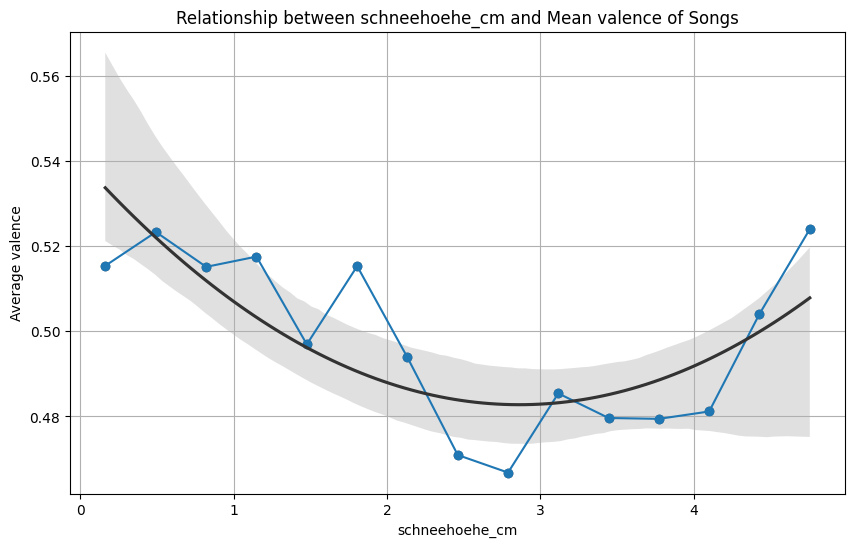

In [ ]:
merged_df = merged_df[merged_df["schneehoehe_cm"] > 0]
sns.pairplot(merged_df, kind="hist", x_vars=["schneehoehe_cm"] + x_vars, y_vars=["schneehoehe_cm"])
plt.show()
merged_df = merged_df[merged_df["schneehoehe_cm"] <= 5]
plot_lines(merged_df, "schneehoehe_cm", 15, 2)

### Machine Learning
#### Random Forest (supervised)

In [11]:
# split data
merged_df = cloud_df
merged_df = merged_df.merge(rain_df, on="date")
merged_df = merged_df.merge(temperature_df, on="date")
merged_df = merged_df.merge(wind_df, on="date")
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")

merged_df.dropna(inplace=True)

merged_df["bedeckungsgrad"] = merged_df["bedeckungsgrad"].astype("float64")
merged_df["niederschlagshoehe_mm"] = merged_df["niederschlagshoehe_mm"].astype("float64")
merged_df["schneehoehe_cm"] = merged_df["schneehoehe_cm"].astype("float64")
merged_df["neuschneehoehe_cm"] = merged_df["neuschneehoehe_cm"].astype("float64")
merged_df["lufttemperatur"] = merged_df["lufttemperatur"].astype("float64")
merged_df["rel_feuchte"] = merged_df["rel_feuchte"].astype("float64")
merged_df["windstaerke"] = merged_df["windstaerke"].astype("float64")

merged_df.columns = merged_df.columns.map(str)

print(merged_df.info())

x_df = merged_df.drop(["position", "date", "track_id", "track", "title", "artist", "niederschlagsform"], axis=1) # NOTE: "niederschlagsform" is droped because I had problems with it
y_df = merged_df["position"]

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.25)

<class 'pandas.core.frame.DataFrame'>
Index: 274225 entries, 0 to 274998
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   274225 non-null  object 
 1   bedeckungsgrad         274225 non-null  float64
 2   niederschlagshoehe_mm  274225 non-null  float64
 3   niederschlagsform      274225 non-null  object 
 4   schneehoehe_cm         274225 non-null  float64
 5   neuschneehoehe_cm      274225 non-null  float64
 6   lufttemperatur         274225 non-null  float64
 7   rel_feuchte            274225 non-null  float64
 8   windstaerke            274225 non-null  float64
 9   position               274225 non-null  int64  
 10  track_id               274225 non-null  object 
 11  track                  274225 non-null  object 
 12  title                  274225 non-null  object 
 13  artist                 274225 non-null  object 
 14  acousticness           274225 non-null  f

In [12]:
# fit random forest
SEED = 42
rf = RandomForestRegressor()
rfr = RandomForestRegressor(random_state=SEED)

rfr.fit(x_train, y_train)

mean_value = np.mean(y_train)
y_pred_mean = np.full_like(y_test, mean_value)
mse_mean = mean_squared_error(y_test, y_pred_mean)
print("Mean MSE (Baseline):", mse_mean)

y_pred = rfr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f"RandomForestRegressor MSE: {mse}")

Mean MSE (Baseline): 3329.018903977712
RandomForestRegressor MSE: 788.6812897413829


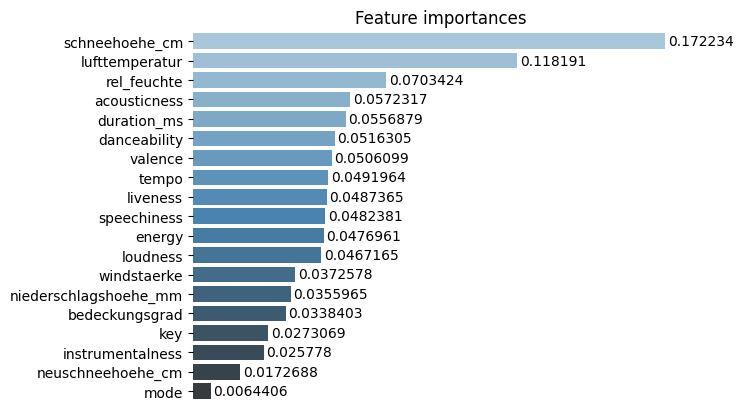

In [18]:
# visualize ranking of feature importances
features_df = pd.DataFrame({"features": rfr.feature_names_in_, "importances": rfr.feature_importances_ })
features_df_sorted = features_df.sort_values(by="importances", ascending=False)

plot = sns.barplot(data=features_df_sorted, x="importances", y ="features", palette="Blues_d")
sns.despine(bottom = True, left = True)
plot.set_title("Feature importances")
plot.set(xlabel=None)
plot.set(ylabel=None)
plot.set(xticks=[])
for value in plot.containers:
    plot.bar_label(value, padding=2)
plt.show()

#### Clustering (unsupervised)

In [ ]:
# Convert the audio features dataframe to a numpy array
selected_cols = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo"]
data = audio_features_df[selected_cols].values

# linear models are to susceptible to outliers. normalization is necessary to counteract this.
scaler = StandardScaler()
data = scaler.fit_transform(data)

[1219.8597068525844, 1013.039074234615, 1038.990329448822, 997.6025042198407, 964.8294295038795, 935.2655666892014, 887.1898106525299, 854.5982301226918, 815.8810132528105, 789.5739439999833]
Optimal number of clusters: 2


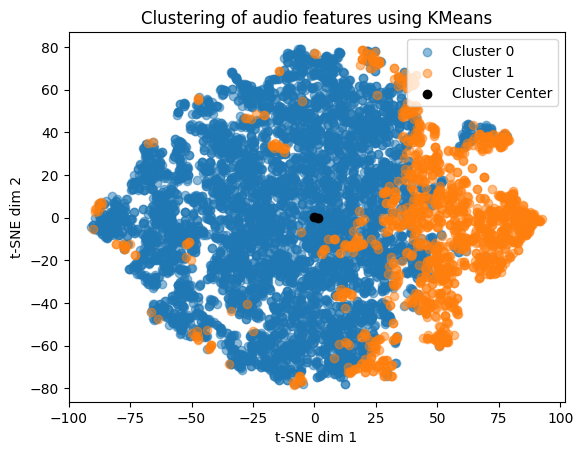

In [ ]:
# Determine the optimal number of clusters using Calinski-Harabasz index
calinski_scores = []
for n_clusters in range(2, 12):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
    labels = kmeans.fit_predict(data)
    calinski_scores.append(calinski_harabasz_score(data, labels))

optimal_n_clusters = np.argmax(calinski_scores) + 2  # Add 2 because range started at 2!

print(calinski_scores)
print(f"Optimal number of clusters: {optimal_n_clusters}")

# Perform KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=0, n_init="auto")
labels = kmeans.fit_predict(data)

# Get mean points of each cluster
cluster_centers = kmeans.cluster_centers_

# Visualize the clusters using t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(data)

# Plot
for label in np.unique(labels):
    cluster_points = tsne_data[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=.5, label=f"Cluster {label}")

# Highlight mean points
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c="black", label="Cluster Center")

plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.title("Clustering of audio features using KMeans")
plt.legend()
plt.show()

# -> not great...